# Preliminary Analysis of CoronaVirus Time Series Data
In this notebook we will conduct some preliminary analysis and forecasting on the Coronavirus time seires data. For this analysis we will look at forecasting using the data scraper.

**Warning this is a basic analysis/machine learning model. The goal of this notebook is to gage the utility of data augmentation/transfer learning for virus forecasting. NOT provide actionable insights. It would additional rounds of training/validation + verification by epidemiologists and public health experts before I would be confident relying on using it for any actionable insights**

In [0]:
#!git clone https://github.com/CoronaWhy/task-geo.git
#!os.chdir('task-geo')
import pandas as pd
!wget -O coronavirus_timeseries.csv https://coronadatascraper.com/timeseries.csv
!pip install wandb
!wandb login
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback 

--2020-04-29 15:59:15--  https://coronadatascraper.com/timeseries.csv
Resolving coronadatascraper.com (coronadatascraper.com)... 185.199.110.153, 185.199.111.153, 185.199.108.153
Connecting to coronadatascraper.com (coronadatascraper.com)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37176877 (35M) [text/csv]
Saving to: ‘coronavirus_timeseries.csv’

coronavirus_timeser 100%[===================>]  35.45M  89.0MB/s    in 0.4s    

2020-04-29 15:59:16 (89.0 MB/s) - ‘coronavirus_timeseries.csv’ saved [37176877/37176877]

     |████████████████████████████████| 1.4MB 4.8MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 460kB 50.3MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 112kB 50.2MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
  Created wheel for subprocess32: filename=sub

In [0]:
df = pd.read_csv("coronavirus_timeseries.csv")
df['month'] = pd.to_datetime(df['date']).map(lambda x: x.month)
df['weekday'] = pd.to_datetime(df['date']).map(lambda x: x.weekday())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
unqiue_counties = df['county'].unique()
print(len(unqiue_counties))

2015


We will now construct a list of suitable data at the county level.

In [0]:
def loop_through_geo_codes(df):
  df_county_list = []
  df['state_county'] = df['state'] + "_" + df['county'] 
  for code in df['full_county'].unique():
    mask = df['full_county'] == code
    df_code = df[mask]
    ts_count = len(df_code)
    if ts_count > 60:
      df_county_list.append(df_code)
  return df_county_list 
county_info = loop_through_geo_codes(df)
print(len(county_info))

38


## Forecasting in Antwerp
We will now piece together some simple tutorial code for forecasting new cases in Antwerp.

In [8]:
antwerp_df = df[df['county']=='Antwerp'].fillna(0)
antwerp_relevant = antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']].values
antwerp_df['new_cases'] = antwerp_df.cases.diff()
print(len(antwerp_df))

98


## Data Augmentation
We will now explore using the tsaug library for forecasting.

In [0]:
!pip install tsaug

In [0]:
from tsaug.visualization import plot 
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (TimeWarp() * 5, # random time warping 5 times in parallel 
                Crop(size=300),  # random crop subsequences with length 300
                Quantize(n_levels=[10, 20, 30]),  # random quantize to 10-, 20-, or 30- level sets
                Drift(max_drift=(0.1, 0.5)),   # with 80% probability, random drift the signal up to 10% - 50%
                Reverse()) #0.5  # with 50% probability, reverse the sequence)

In [0]:
#X_aug = my_augmenter[0].augment(antwerp_relevant)
print(antwerp_relevant.shape)
X_aug = TimeWarp(antwerp[:70])

## Models and Forecasting
We will now define some simple models in Keras for forecasting.

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
scaler_dict = {}
config_default = {"epochs":30, "validation_split":0.1, 
          "loss":"mean_squared_error", "optimizer":'adam', 
          "geo_segment":"antwerp", "seq_len":7, "train_steps":70, 
          "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
          "beta":0.899, "additional_features":["weekday","month"]}
r = RobustScaler()
x_train_full = antwerp_df[['deaths', 'new_cases']][1:config_default["train_steps"]]
x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
y_train_full = x_train_full
r_test = RobustScaler()
test_orig = antwerp_df[['deaths', 'new_cases']][70:]
test = pd.DataFrame(r_test.fit_transform(test_orig))

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [11]:
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2, 3, 4, 5]
        },
        "learn":{
            "values":[0.001, 0.002, 0.004, 0.01]
        },
        "seq_len":{
            "values":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="covid-forecast")

Create sweep with ID: t1k72707
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/t1k72707


In [0]:
import matplotlib.pyplot as plt
def train(x_train_full, y_train_full, test, test, config_default):
  run = wandb.init(project="covid-forecast", config=config_default, magic=True)
  config = wandb.config
  X_train, Y_train = create_dataset(x_train_full, y_train_full, config["seq_len"])
  X_test, y_test = create_dataset(test, test, config["seq_len"])
  opt = keras.optimizers.Adam(learning_rate=config["learn"], beta_1=config["beta"], beta_2=0.999, amsgrad=False)
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  ) 
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=2))
  model.compile(loss=config["loss"], optimizer=opt)

  history = model.fit(
      X_train, Y_train,
      epochs=config["epochs"],
      batch_size=config["batch_size"],
      validation_split=config["validation_split"],
      callbacks=[WandbCallback()],
      shuffle=False
  )
  evaluate_single(model, X_test, y_test, r)
  evaluate_plot_multi(model, test, config, X_test, r_test)
  return model

def evaluate_single(model, x_test, y_test, scaler):
  y_preds = model.predict(x_test)
  y_preds = scaler.inverse_transform(y_preds)
  y_test = scaler.inverse_transform(y_test)
  complete_mse = tf.keras.losses.MSE( y_preds[:, 1], y_test[:, 1])
  wandb.run.summary["test_mse"] = complete_mse
  return complete_mse

def evaluate_plot_multi(model, test_df, config, x_test, scaler, predictor="new_cases"):
  arr = predict_multi(model, len(test)-config["seq_len"], x_test[0, :, :], config)
  test_orig['predicted_cases'] = 0
  test_orig['predicted_cases'][config["seq_len"]:] = scaler.inverse_transform(arr.squeeze(0))[:, 1]
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.log({"test":plt})
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.Image(plt, caption="Plot")
  large_mse = tf.keras.losses.MSE(
    scaler.inverse_transform(arr.squeeze(0))[:, 1], test_orig[predictor][config["seq_len"]:].values
  )
  wandb.run.summary["test_mse_full"] =  large_mse
  return large_mse

def predict_multi(model, time_steps, start_rows, config):
  start_rows=np.expand_dims(start_rows, axis=0)
  for i in range(0, time_steps):
    out = model.predict(start_rows[:, i:, :])
    out = out[np.newaxis, ...]
    start_rows = np.concatenate((start_rows, out), axis=1)
  return start_rows[:, config["seq_len"]:, :]


In [0]:
wandb.agent(sweep_id, function=train)


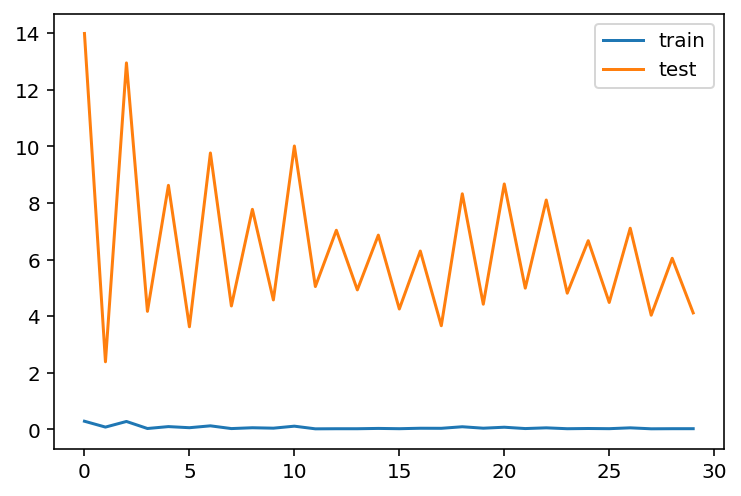

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Forecasting on all county levels
Now that we have loooked at Antwerp specifically we will design a general function to work on all geographic counties.

In [0]:
# TODO figure out how to get this into a function. Horrible to use global vars 
#like this. Still waiting on Slack response though.
#def run_geo_sweeps(county_info):
# refactor
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
def run_geo_sweeps(county_info, start_idx=0, end_idx=1):
  for s in range(start_idx, end_idx):
    county = county_info[s].fillna(0)
    county_name = county['full_county'].values[0]
    config_default = {"epochs":30, "validation_split":0.1, 
            "loss":"mean_squared_error", "optimizer":'adam', 
            "geo_segment":county_name, "seq_len":7, "train_steps":60, 
            "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
            "beta":0.899, "additional_features":["none"]}
    county['new_cases'] = county.cases.diff()
    r = RobustScaler()
    x_train_full = county[['deaths', 'new_cases']][1:config_default["train_steps"]]
    x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
    y_train_full = x_train_full
    r_test = RobustScaler()
    test_orig = county[['deaths', 'new_cases']][60:]
    test = pd.DataFrame(r_test.fit_transform(test_orig))
    sweep_id = wandb.sweep(sweep_config, project="covid-forecast")
    wandb.agent(sweep_id, lambda:train(x_train_full, y_train_full, test, test, config_default))


In [25]:
run_geo_sweeps(county_info, 2, 3)

Create sweep with ID: 0n0e72uf
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/0n0e72uf
wandb: Agent Starting Run: mrl1p0ds with config:
	batch_size: 2
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: mrl1p0ds


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 1s 29ms/step - loss: 1.0520 - val_loss: 14.4885
Epoch 2/30
31/31 [==============================] - 0s 5ms/step - loss: 0.8857 - val_loss: 11.7311
Epoch 3/30
31/31 [==============================] - 0s 5ms/step - loss: 0.7245 - val_loss: 9.5209
Epoch 4/30
31/31 [==============================] - 0s 7ms/step - loss: 0.6034 - val_loss: 7.5707
Epoch 5/30
31/31 [==============================] - 0s 6ms/step - loss: 0.4976 - val_loss: 5.8720
Epoch 6/30
31/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mrl1p0ds 

wandb: Agent Starting Run: dz3ptznf with config:
	batch_size: 2
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: dz3ptznf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 30ms/step - loss: 0.6838 - val_loss: 10.2000
Epoch 2/30
30/30 [==============================] - 0s 8ms/step - loss: 0.4274 - val_loss: 5.0850
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2817 - val_loss: 2.3468
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2250 - val_loss: 1.6609
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2078 - val_loss: 2.1082
Epoch 6/30
30/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dz3ptznf 

wandb: Agent Starting Run: tor7dv48 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: tor7dv48


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 31ms/step - loss: 0.8484 - val_loss: 8.2402
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.3643 - val_loss: 2.0161
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2347 - val_loss: 1.9170
Epoch 4/30
30/30 [==============================] - 0s 8ms/step - loss: 0.2095 - val_loss: 2.9294
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2260 - val_loss: 3.5084
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tor7dv48 

wandb: Agent Starting Run: 2e3tnqfa with config:
	batch_size: 2
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: 2e3tnqfa


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 32ms/step - loss: 0.5952 - val_loss: 6.3096
Epoch 2/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2309 - val_loss: 1.3314
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2015 - val_loss: 2.1038
Epoch 4/30
29/29 [==============================] - 0s 7ms/step - loss: 0.1748 - val_loss: 1.7142
Epoch 5/30
29/29 [==============================] - 0s 6ms/step - loss: 0.1586 - val_loss: 2.8653
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2e3tnqfa 

wandb: Agent Starting Run: 2dojyij4 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: 2dojyij4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 35ms/step - loss: 0.7036 - val_loss: 4.9285
Epoch 2/30
29/29 [==============================] - 0s 9ms/step - loss: 0.2105 - val_loss: 1.5907
Epoch 3/30
29/29 [==============================] - 0s 9ms/step - loss: 0.2340 - val_loss: 3.2777
Epoch 4/30
29/29 [==============================] - 0s 10ms/step - loss: 0.2331 - val_loss: 2.3825
Epoch 5/30
29/29 [==============================] - 0s 8ms/step - loss: 0.2459 - val_loss: 4.2333
Epoch 6/30
29/29

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2dojyij4 

wandb: Agent Starting Run: 6twxooix with config:
	batch_size: 2
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: 6twxooix


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 36ms/step - loss: 0.4149 - val_loss: 2.9506
Epoch 2/30
28/28 [==============================] - 0s 9ms/step - loss: 0.2002 - val_loss: 1.8679
Epoch 3/30
28/28 [==============================] - 0s 8ms/step - loss: 0.1598 - val_loss: 2.0172
Epoch 4/30
28/28 [==============================] - 0s 9ms/step - loss: 0.1993 - val_loss: 2.7510
Epoch 5/30
28/28 [==============================] - 0s 9ms/step - loss: 0.2051 - val_loss: 2.0104
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6twxooix 

wandb: Agent Starting Run: 4pni7gdv with config:
	batch_size: 2
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: 4pni7gdv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 38ms/step - loss: 0.5082 - val_loss: 2.4668
Epoch 2/30
28/28 [==============================] - 0s 11ms/step - loss: 0.2309 - val_loss: 1.9536
Epoch 3/30
28/28 [==============================] - 0s 12ms/step - loss: 0.2263 - val_loss: 1.5187
Epoch 4/30
28/28 [==============================] - 0s 9ms/step - loss: 0.3032 - val_loss: 2.5854
Epoch 5/30
28/28 [==============================] - 0s 10ms/step - loss: 0.5408 - val_loss: 2.5603
Epoch 6/30
28/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4pni7gdv 

wandb: Agent Starting Run: zqyhpr47 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: zqyhpr47


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 37ms/step - loss: 0.4199 - val_loss: 2.3807
Epoch 2/30
27/27 [==============================] - 0s 10ms/step - loss: 0.2182 - val_loss: 1.7071
Epoch 3/30
27/27 [==============================] - 0s 10ms/step - loss: 0.2289 - val_loss: 1.3735
Epoch 4/30
27/27 [==============================] - 0s 9ms/step - loss: 0.2411 - val_loss: 2.5238
Epoch 5/30
27/27 [==============================] - 0s 12ms/step - loss: 0.2898 - val_loss: 1.3663
Epoch 6/30
27/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zqyhpr47 

wandb: Agent Starting Run: wm6nwc7r with config:
	batch_size: 2
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: wm6nwc7r


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 37ms/step - loss: 0.4478 - val_loss: 1.8695
Epoch 2/30
27/27 [==============================] - 0s 9ms/step - loss: 0.2854 - val_loss: 2.3357
Epoch 3/30
27/27 [==============================] - 0s 10ms/step - loss: 0.4669 - val_loss: 1.5628
Epoch 4/30
27/27 [==============================] - 0s 11ms/step - loss: 0.2500 - val_loss: 2.3958
Epoch 5/30
27/27 [==============================] - 0s 11ms/step - loss: 0.3932 - val_loss: 1.8465
Epoch 6/30
27/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wm6nwc7r 

wandb: Agent Starting Run: ny8hnj8z with config:
	batch_size: 2
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: ny8hnj8z


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 41ms/step - loss: 0.4061 - val_loss: 1.3605
Epoch 2/30
27/27 [==============================] - 0s 14ms/step - loss: 0.4546 - val_loss: 2.6073
Epoch 3/30
27/27 [==============================] - 0s 13ms/step - loss: 0.6052 - val_loss: 1.6287
Epoch 4/30
27/27 [==============================] - 0s 12ms/step - loss: 0.1996 - val_loss: 2.9073
Epoch 5/30
27/27 [==============================] - 0s 14ms/step - loss: 0.2952 - val_loss: 1.6672
Epoch 6/30
27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ny8hnj8z 

wandb: Agent Starting Run: tfq05872 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: tfq05872


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 1s 28ms/step - loss: 0.8614 - val_loss: 11.0908
Epoch 2/30
31/31 [==============================] - 0s 5ms/step - loss: 0.5451 - val_loss: 6.6829
Epoch 3/30
31/31 [==============================] - 0s 5ms/step - loss: 0.3867 - val_loss: 3.7820
Epoch 4/30
31/31 [==============================] - 0s 6ms/step - loss: 0.2872 - val_loss: 2.2323
Epoch 5/30
31/31 [==============================] - 0s 7ms/step - loss: 0.2263 - val_loss: 1.7501
Epoch 6/30
31/31

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tfq05872 

wandb: Agent Starting Run: cfbpkh7v with config:
	batch_size: 2
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: cfbpkh7v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 30ms/step - loss: 0.5763 - val_loss: 6.6751
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2566 - val_loss: 1.7768
Epoch 3/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2009 - val_loss: 2.2321
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.1890 - val_loss: 2.5397
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2328 - val_loss: 2.5894
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cfbpkh7v 

wandb: Agent Starting Run: rzfihe5t with config:
	batch_size: 2
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: rzfihe5t


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 32ms/step - loss: 0.3804 - val_loss: 1.6009
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.3227 - val_loss: 3.1981
Epoch 3/30
30/30 [==============================] - 0s 8ms/step - loss: 0.2624 - val_loss: 1.5835
Epoch 4/30
30/30 [==============================] - 0s 7ms/step - loss: 0.3282 - val_loss: 2.8868
Epoch 5/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5535 - val_loss: 3.5318
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rzfihe5t 

wandb: Agent Starting Run: zmnyrbg4 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: zmnyrbg4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 32ms/step - loss: 0.3038 - val_loss: 1.3391
Epoch 2/30
29/29 [==============================] - 0s 8ms/step - loss: 0.2922 - val_loss: 3.3302
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.3228 - val_loss: 1.3978
Epoch 4/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2247 - val_loss: 3.6285
Epoch 5/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2464 - val_loss: 1.7246
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zmnyrbg4 

wandb: Agent Starting Run: s6o4n2ws with config:
	batch_size: 2
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: s6o4n2ws


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 34ms/step - loss: 0.2100 - val_loss: 2.2011
Epoch 2/30
29/29 [==============================] - 0s 8ms/step - loss: 0.5498 - val_loss: 2.2559
Epoch 3/30
29/29 [==============================] - 0s 10ms/step - loss: 0.8334 - val_loss: 3.9022
Epoch 4/30
29/29 [==============================] - 0s 9ms/step - loss: 0.1885 - val_loss: 1.5011
Epoch 5/30
29/29 [==============================] - 0s 8ms/step - loss: 0.1992 - val_loss: 2.4278
Epoch 6/30
29/29

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: s6o4n2ws 

wandb: Agent Starting Run: 65ez6nj4 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: 65ez6nj4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 34ms/step - loss: 0.2030 - val_loss: 1.4067
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.2431 - val_loss: 2.5218
Epoch 3/30
28/28 [==============================] - 0s 8ms/step - loss: 0.1860 - val_loss: 2.2456
Epoch 4/30
28/28 [==============================] - 0s 10ms/step - loss: 0.2545 - val_loss: 3.1043
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.5074 - val_loss: 3.9269
Epoch 6/30
28/28

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 65ez6nj4 

wandb: Agent Starting Run: e3kfpm77 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: e3kfpm77


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 38ms/step - loss: 0.1826 - val_loss: 1.6656
Epoch 2/30
28/28 [==============================] - 0s 10ms/step - loss: 0.4041 - val_loss: 1.8606
Epoch 3/30
28/28 [==============================] - 0s 12ms/step - loss: 0.3065 - val_loss: 2.6013
Epoch 4/30
28/28 [==============================] - 0s 10ms/step - loss: 0.4889 - val_loss: 1.8459
Epoch 5/30
28/28 [==============================] - 0s 10ms/step - loss: 0.8621 - val_loss: 5.7970
Epoch 6/30
28

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: e3kfpm77 

wandb: Agent Starting Run: 501j2y9k with config:
	batch_size: 2
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: 501j2y9k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 38ms/step - loss: 0.2251 - val_loss: 1.1883
Epoch 2/30
27/27 [==============================] - 0s 9ms/step - loss: 0.2118 - val_loss: 1.5653
Epoch 3/30
27/27 [==============================] - 0s 9ms/step - loss: 0.2011 - val_loss: 1.6899
Epoch 4/30
27/27 [==============================] - 0s 9ms/step - loss: 0.2747 - val_loss: 2.1725
Epoch 5/30
27/27 [==============================] - 0s 12ms/step - loss: 0.2636 - val_loss: 2.6906
Epoch 6/30
27/27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 501j2y9k 

wandb: Agent Starting Run: 419xocjv with config:
	batch_size: 2
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: 419xocjv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 39ms/step - loss: 0.2150 - val_loss: 1.4174
Epoch 2/30
27/27 [==============================] - 0s 10ms/step - loss: 0.1996 - val_loss: 2.8239
Epoch 3/30
27/27 [==============================] - 0s 10ms/step - loss: 0.3109 - val_loss: 2.8665
Epoch 4/30
27/27 [==============================] - 0s 12ms/step - loss: 0.3120 - val_loss: 5.2397
Epoch 5/30
27/27 [==============================] - 0s 10ms/step - loss: 0.3194 - val_loss: 5.1289
Epoch 6/30
27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 419xocjv 

wandb: Agent Starting Run: nffq53p6 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: nffq53p6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 41ms/step - loss: 0.3136 - val_loss: 1.4221
Epoch 2/30
27/27 [==============================] - 0s 14ms/step - loss: 0.5245 - val_loss: 2.1193
Epoch 3/30
27/27 [==============================] - 0s 12ms/step - loss: 0.4111 - val_loss: 1.5415
Epoch 4/30
27/27 [==============================] - 0s 13ms/step - loss: 0.7845 - val_loss: 2.4624
Epoch 5/30
27/27 [==============================] - 0s 14ms/step - loss: 0.2255 - val_loss: 1.7219
Epoch 6/30
27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nffq53p6 

wandb: Agent Starting Run: 8u0r8uoi with config:
	batch_size: 2
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: 8u0r8uoi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 1s 29ms/step - loss: 0.6280 - val_loss: 6.0839
Epoch 2/30
31/31 [==============================] - 0s 5ms/step - loss: 0.2830 - val_loss: 1.8574
Epoch 3/30
31/31 [==============================] - 0s 5ms/step - loss: 0.2515 - val_loss: 2.2119
Epoch 4/30
31/31 [==============================] - 0s 7ms/step - loss: 0.2339 - val_loss: 1.7395
Epoch 5/30
31/31 [==============================] - 0s 6ms/step - loss: 0.2404 - val_loss: 2.4302
Epoch 6/30
31/31 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8u0r8uoi 

wandb: Agent Starting Run: b6irtsr4 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: b6irtsr4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 30ms/step - loss: 0.2954 - val_loss: 1.8048
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.3178 - val_loss: 3.9399
Epoch 3/30
30/30 [==============================] - 0s 5ms/step - loss: 0.2124 - val_loss: 2.4047
Epoch 4/30
30/30 [==============================] - 0s 5ms/step - loss: 0.2394 - val_loss: 2.1575
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.3807 - val_loss: 3.7879
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: b6irtsr4 

wandb: Agent Starting Run: q0imo1hc with config:
	batch_size: 2
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: q0imo1hc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 32ms/step - loss: 0.2245 - val_loss: 1.7976
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.4596 - val_loss: 1.8271
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.3922 - val_loss: 1.4181
Epoch 4/30
30/30 [==============================] - 0s 8ms/step - loss: 0.4493 - val_loss: 2.7606
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.8090 - val_loss: 5.9930
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q0imo1hc 

wandb: Agent Starting Run: 0yn1gj1v with config:
	batch_size: 2
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: 0yn1gj1v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 34ms/step - loss: 0.2424 - val_loss: 1.4761
Epoch 2/30
29/29 [==============================] - 0s 8ms/step - loss: 0.3813 - val_loss: 1.4390
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2277 - val_loss: 1.5621
Epoch 4/30
29/29 [==============================] - 0s 6ms/step - loss: 0.1851 - val_loss: 2.0672
Epoch 5/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2271 - val_loss: 2.3356
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0yn1gj1v 

wandb: Agent Starting Run: elwtqin5 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: elwtqin5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 35ms/step - loss: 0.2432 - val_loss: 1.2923
Epoch 2/30
29/29 [==============================] - 0s 9ms/step - loss: 0.6082 - val_loss: 4.4041
Epoch 3/30
29/29 [==============================] - 0s 9ms/step - loss: 0.7124 - val_loss: 1.8093
Epoch 4/30
29/29 [==============================] - 0s 9ms/step - loss: 0.7298 - val_loss: 4.9446
Epoch 5/30
29/29 [==============================] - 0s 9ms/step - loss: 0.3576 - val_loss: 1.5201
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: elwtqin5 

wandb: Agent Starting Run: 7pyux48e with config:
	batch_size: 2
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: 7pyux48e


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 37ms/step - loss: 0.2464 - val_loss: 1.3347
Epoch 2/30
28/28 [==============================] - 0s 9ms/step - loss: 0.4009 - val_loss: 2.0896
Epoch 3/30
28/28 [==============================] - 0s 9ms/step - loss: 0.5223 - val_loss: 1.7022
Epoch 4/30
28/28 [==============================] - 0s 11ms/step - loss: 0.6184 - val_loss: 4.8967
Epoch 5/30
28/28 [==============================] - 0s 9ms/step - loss: 0.2932 - val_loss: 1.2151
Epoch 6/30
28/28

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7pyux48e 

wandb: Agent Starting Run: e17llql7 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: e17llql7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 40ms/step - loss: 0.2244 - val_loss: 2.4049
Epoch 2/30
28/28 [==============================] - 0s 12ms/step - loss: 0.3483 - val_loss: 3.4009
Epoch 3/30
28/28 [==============================] - 0s 12ms/step - loss: 0.6240 - val_loss: 1.7685
Epoch 4/30
28/28 [==============================] - 0s 10ms/step - loss: 0.1321 - val_loss: 1.9143
Epoch 5/30
28/28 [==============================] - 0s 14ms/step - loss: 0.2398 - val_loss: 1.7038
Epoch 6/30
28

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: e17llql7 

wandb: Agent Starting Run: 44dkbcw4 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: 44dkbcw4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 38ms/step - loss: 0.2586 - val_loss: 1.1175
Epoch 2/30
27/27 [==============================] - 0s 9ms/step - loss: 0.2996 - val_loss: 3.5137
Epoch 3/30
27/27 [==============================] - 0s 10ms/step - loss: 0.6742 - val_loss: 1.7852
Epoch 4/30
27/27 [==============================] - 0s 10ms/step - loss: 0.3177 - val_loss: 1.4251
Epoch 5/30
27/27 [==============================] - 0s 13ms/step - loss: 0.4069 - val_loss: 1.0450
Epoch 6/30
27/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 44dkbcw4 

wandb: Agent Starting Run: 67797bwt with config:
	batch_size: 2
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: 67797bwt


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 41ms/step - loss: 0.3495 - val_loss: 1.5748
Epoch 2/30
27/27 [==============================] - 0s 10ms/step - loss: 0.4563 - val_loss: 3.2800
Epoch 3/30
27/27 [==============================] - 0s 11ms/step - loss: 0.5360 - val_loss: 8.9635
Epoch 4/30
27/27 [==============================] - 0s 12ms/step - loss: 0.9153 - val_loss: 1.8728
Epoch 5/30
27/27 [==============================] - 0s 11ms/step - loss: 0.2307 - val_loss: 2.1163
Epoch 6/30
27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 67797bwt 

wandb: Agent Starting Run: 8ty1qqgo with config:
	batch_size: 2
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: 8ty1qqgo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 42ms/step - loss: 0.2876 - val_loss: 1.7049
Epoch 2/30
27/27 [==============================] - 0s 15ms/step - loss: 0.4812 - val_loss: 7.8869
Epoch 3/30
27/27 [==============================] - 0s 13ms/step - loss: 0.6732 - val_loss: 2.5217
Epoch 4/30
27/27 [==============================] - 0s 13ms/step - loss: 0.8547 - val_loss: 1.7837
Epoch 5/30
27/27 [==============================] - 0s 15ms/step - loss: 1.2968 - val_loss: 9.5266
Epoch 6/30
27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8ty1qqgo 

wandb: Agent Starting Run: 98j4khyi with config:
	batch_size: 2
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: 98j4khyi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 1s 29ms/step - loss: 0.2110 - val_loss: 1.6533
Epoch 2/30
31/31 [==============================] - 0s 5ms/step - loss: 0.3326 - val_loss: 1.9333
Epoch 3/30
31/31 [==============================] - 0s 6ms/step - loss: 0.2102 - val_loss: 1.4881
Epoch 4/30
31/31 [==============================] - 0s 6ms/step - loss: 0.2395 - val_loss: 1.6491
Epoch 5/30
31/31 [==============================] - 0s 5ms/step - loss: 0.3984 - val_loss: 2.2950
Epoch 6/30
31/31 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 98j4khyi 

wandb: Agent Starting Run: 8z1tojd1 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: 8z1tojd1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 32ms/step - loss: 0.2239 - val_loss: 1.5331
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.4040 - val_loss: 1.8526
Epoch 3/30
30/30 [==============================] - 0s 6ms/step - loss: 0.3171 - val_loss: 2.0384
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2923 - val_loss: 1.5993
Epoch 5/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5121 - val_loss: 1.8464
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8z1tojd1 

wandb: Agent Starting Run: 62sl2rbd with config:
	batch_size: 2
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: 62sl2rbd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 32ms/step - loss: 0.2188 - val_loss: 2.6735
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.4534 - val_loss: 8.0977
Epoch 3/30
30/30 [==============================] - 0s 8ms/step - loss: 0.4246 - val_loss: 1.9285
Epoch 4/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5992 - val_loss: 2.1508
Epoch 5/30
30/30 [==============================] - 0s 7ms/step - loss: 0.3767 - val_loss: 1.3570
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 62sl2rbd 

wandb: Agent Starting Run: zg3vdphl with config:
	batch_size: 2
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: zg3vdphl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 33ms/step - loss: 0.3460 - val_loss: 2.8124
Epoch 2/30
29/29 [==============================] - 0s 7ms/step - loss: 0.3853 - val_loss: 3.7271
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.5973 - val_loss: 1.4467
Epoch 4/30
29/29 [==============================] - 0s 8ms/step - loss: 0.3380 - val_loss: 1.4806
Epoch 5/30
29/29 [==============================] - 0s 8ms/step - loss: 0.6886 - val_loss: 4.3419
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zg3vdphl 

wandb: Agent Starting Run: 38w63gnn with config:
	batch_size: 2
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: 38w63gnn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 36ms/step - loss: 0.3918 - val_loss: 1.5194
Epoch 2/30
29/29 [==============================] - 0s 9ms/step - loss: 0.3287 - val_loss: 3.4342
Epoch 3/30
29/29 [==============================] - 0s 12ms/step - loss: 0.2723 - val_loss: 1.1607
Epoch 4/30
29/29 [==============================] - 0s 8ms/step - loss: 0.4748 - val_loss: 9.6938
Epoch 5/30
29/29 [==============================] - 0s 9ms/step - loss: 0.2988 - val_loss: 1.3995
Epoch 6/30
29/29

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 38w63gnn 

wandb: Agent Starting Run: 97n1udjy with config:
	batch_size: 2
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: 97n1udjy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 35ms/step - loss: 0.3608 - val_loss: 2.6576
Epoch 2/30
28/28 [==============================] - 0s 9ms/step - loss: 0.3582 - val_loss: 1.3532
Epoch 3/30
28/28 [==============================] - 0s 9ms/step - loss: 0.2616 - val_loss: 1.1126
Epoch 4/30
28/28 [==============================] - 0s 9ms/step - loss: 0.4717 - val_loss: 2.1517
Epoch 5/30
28/28 [==============================] - 0s 11ms/step - loss: 0.4377 - val_loss: 2.8204
Epoch 6/30
28/28

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 97n1udjy 

wandb: Agent Starting Run: gxp25ozt with config:
	batch_size: 2
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: gxp25ozt


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 38ms/step - loss: 0.4460 - val_loss: 1.6717
Epoch 2/30
28/28 [==============================] - 0s 11ms/step - loss: 0.2737 - val_loss: 1.0641
Epoch 3/30
28/28 [==============================] - 0s 12ms/step - loss: 0.2641 - val_loss: 1.1547
Epoch 4/30
28/28 [==============================] - 0s 9ms/step - loss: 1.3994 - val_loss: 5.5995
Epoch 5/30
28/28 [==============================] - 0s 10ms/step - loss: 0.2770 - val_loss: 4.7119
Epoch 6/30
28/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gxp25ozt 

wandb: Agent Starting Run: nxpyi63y with config:
	batch_size: 2
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: nxpyi63y


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 38ms/step - loss: 0.4014 - val_loss: 2.6730
Epoch 2/30
27/27 [==============================] - 0s 10ms/step - loss: 0.2408 - val_loss: 1.8187
Epoch 3/30
27/27 [==============================] - 0s 10ms/step - loss: 0.3094 - val_loss: 1.3840
Epoch 4/30
27/27 [==============================] - 0s 9ms/step - loss: 0.6619 - val_loss: 1.6917
Epoch 5/30
27/27 [==============================] - 0s 13ms/step - loss: 0.4223 - val_loss: 1.0293
Epoch 6/30
27/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nxpyi63y 



wandb: Network error resolved after 0:00:32.702301, resuming normal operation.


wandb: Agent Starting Run: xwz9rhkv with config:
	batch_size: 2
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: xwz9rhkv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 38ms/step - loss: 0.4316 - val_loss: 1.5933
Epoch 2/30
27/27 [==============================] - 0s 9ms/step - loss: 0.7926 - val_loss: 2.0270
Epoch 3/30
27/27 [==============================] - 0s 10ms/step - loss: 0.1999 - val_loss: 1.8384
Epoch 4/30
27/27 [==============================] - 0s 10ms/step - loss: 0.3617 - val_loss: 2.1337
Epoch 5/30
27/27 [==============================] - 0s 12ms/step - loss: 0.3562 - val_loss: 1.5417
Epoch 6/30
27/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xwz9rhkv 

wandb: Agent Starting Run: 5ikkmfp9 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: 5ikkmfp9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 42ms/step - loss: 0.5087 - val_loss: 1.7232
Epoch 2/30
27/27 [==============================] - 0s 14ms/step - loss: 0.3452 - val_loss: 1.6072
Epoch 3/30
27/27 [==============================] - 0s 11ms/step - loss: 1.1561 - val_loss: 2.0565
Epoch 4/30
27/27 [==============================] - 0s 11ms/step - loss: 0.3664 - val_loss: 2.0242
Epoch 5/30
27/27 [==============================] - 0s 15ms/step - loss: 0.2405 - val_loss: 1.4717
Epoch 6/30
27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5ikkmfp9 

wandb: Agent Starting Run: 0jx9cwdc with config:
	batch_size: 3
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: 0jx9cwdc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

21/21 [==============================] - 1s 42ms/step - loss: 1.3448 - val_loss: 15.0518
Epoch 2/30
21/21 [==============================] - 0s 7ms/step - loss: 1.1206 - val_loss: 12.8922
Epoch 3/30
21/21 [==============================] - 0s 7ms/step - loss: 0.9750 - val_loss: 11.0564
Epoch 4/30
21/21 [==============================] - 0s 7ms/step - loss: 0.8676 - val_loss: 9.4218
Epoch 5/30
21/21 [==============================] - 0s 8ms/step - loss: 0.7445 - val_loss: 7.9195
Epoch 6/30
21/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0jx9cwdc 

wandb: Agent Starting Run: nlqngc09 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: nlqngc09


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 46ms/step - loss: 0.8711 - val_loss: 14.8182
Epoch 2/30
20/20 [==============================] - 0s 7ms/step - loss: 0.6584 - val_loss: 9.9243
Epoch 3/30
20/20 [==============================] - 0s 7ms/step - loss: 0.4867 - val_loss: 6.1206
Epoch 4/30
20/20 [==============================] - 0s 7ms/step - loss: 0.3468 - val_loss: 3.2807
Epoch 5/30
20/20 [==============================] - 0s 7ms/step - loss: 0.2712 - val_loss: 1.7692
Epoch 6/30
20/20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nlqngc09 

wandb: Agent Starting Run: 0svbzzum with config:
	batch_size: 3
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: 0svbzzum


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 45ms/step - loss: 1.0665 - val_loss: 12.2502
Epoch 2/30
20/20 [==============================] - 0s 8ms/step - loss: 0.6920 - val_loss: 6.0565
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 0.4601 - val_loss: 2.3133
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2769 - val_loss: 1.2760
Epoch 5/30
20/20 [==============================] - 0s 7ms/step - loss: 0.2511 - val_loss: 2.0529
Epoch 6/30
20/20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0svbzzum 

wandb: Agent Starting Run: omtz4edr with config:
	batch_size: 3
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: omtz4edr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 46ms/step - loss: 1.0861 - val_loss: 9.1869
Epoch 2/30
20/20 [==============================] - 0s 9ms/step - loss: 0.4716 - val_loss: 2.4692
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2347 - val_loss: 1.3686
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 0.1880 - val_loss: 2.5770
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 0.1908 - val_loss: 2.2162
Epoch 6/30
20/20 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: omtz4edr 

wandb: Agent Starting Run: jhx0soj9 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: jhx0soj9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 48ms/step - loss: 0.7431 - val_loss: 9.3408
Epoch 2/30
19/19 [==============================] - 0s 10ms/step - loss: 0.2986 - val_loss: 2.1280
Epoch 3/30
19/19 [==============================] - 0s 10ms/step - loss: 0.1717 - val_loss: 1.8384
Epoch 4/30
19/19 [==============================] - 0s 8ms/step - loss: 0.1568 - val_loss: 2.5944
Epoch 5/30
19/19 [==============================] - 0s 8ms/step - loss: 0.1460 - val_loss: 3.3216
Epoch 6/30
19/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jhx0soj9 

wandb: Agent Starting Run: 832a5vyw with config:
	batch_size: 3
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: 832a5vyw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 50ms/step - loss: 0.7989 - val_loss: 6.3920
Epoch 2/30
19/19 [==============================] - 0s 10ms/step - loss: 0.2827 - val_loss: 1.1343
Epoch 3/30
19/19 [==============================] - 0s 10ms/step - loss: 0.2227 - val_loss: 2.4003
Epoch 4/30
19/19 [==============================] - 0s 12ms/step - loss: 0.1877 - val_loss: 1.6851
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 0.1706 - val_loss: 3.1460
Epoch 6/30
19/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 832a5vyw 

wandb: Agent Starting Run: o5i46xiv with config:
	batch_size: 3
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: o5i46xiv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 52ms/step - loss: 0.9886 - val_loss: 6.4071
Epoch 2/30
19/19 [==============================] - 0s 12ms/step - loss: 0.2083 - val_loss: 1.0925
Epoch 3/30
19/19 [==============================] - 0s 13ms/step - loss: 0.3312 - val_loss: 3.0079
Epoch 4/30
19/19 [==============================] - 0s 12ms/step - loss: 0.2717 - val_loss: 1.1732
Epoch 5/30
19/19 [==============================] - 0s 10ms/step - loss: 0.1846 - val_loss: 3.1754
Epoch 6/30
19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o5i46xiv 

wandb: Agent Starting Run: 1u8jejhl with config:
	batch_size: 3
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: 1u8jejhl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 54ms/step - loss: 0.6401 - val_loss: 6.0199
Epoch 2/30
18/18 [==============================] - 0s 12ms/step - loss: 0.1766 - val_loss: 1.0405
Epoch 3/30
18/18 [==============================] - 0s 10ms/step - loss: 0.2498 - val_loss: 2.4428
Epoch 4/30
18/18 [==============================] - 0s 10ms/step - loss: 0.3213 - val_loss: 1.6055
Epoch 5/30
18/18 [==============================] - 0s 11ms/step - loss: 0.1217 - val_loss: 1.7554
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1u8jejhl 

wandb: Agent Starting Run: 7qpiq4sh with config:
	batch_size: 3
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: 7qpiq4sh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 53ms/step - loss: 0.8303 - val_loss: 6.7433
Epoch 2/30
18/18 [==============================] - 0s 11ms/step - loss: 0.2052 - val_loss: 1.3879
Epoch 3/30
18/18 [==============================] - 0s 10ms/step - loss: 0.2487 - val_loss: 2.8018
Epoch 4/30
18/18 [==============================] - 0s 10ms/step - loss: 0.2796 - val_loss: 1.4486
Epoch 5/30
18/18 [==============================] - 0s 10ms/step - loss: 0.1557 - val_loss: 2.4982
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7qpiq4sh 

wandb: Agent Starting Run: srjoo1g0 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: srjoo1g0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 57ms/step - loss: 0.9729 - val_loss: 5.5467
Epoch 2/30
18/18 [==============================] - 0s 16ms/step - loss: 0.1915 - val_loss: 1.6544
Epoch 3/30
18/18 [==============================] - 0s 17ms/step - loss: 0.2969 - val_loss: 2.5273
Epoch 4/30
18/18 [==============================] - 0s 13ms/step - loss: 0.6639 - val_loss: 2.6124
Epoch 5/30
18/18 [==============================] - 0s 13ms/step - loss: 0.1721 - val_loss: 1.7995
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: srjoo1g0 

wandb: Agent Starting Run: esih3vam with config:
	batch_size: 3
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: esih3vam


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

21/21 [==============================] - 1s 41ms/step - loss: 1.2805 - val_loss: 14.1669
Epoch 2/30
21/21 [==============================] - 0s 7ms/step - loss: 0.9592 - val_loss: 10.4570
Epoch 3/30
21/21 [==============================] - 0s 7ms/step - loss: 0.6978 - val_loss: 7.4773
Epoch 4/30
21/21 [==============================] - 0s 8ms/step - loss: 0.5158 - val_loss: 4.9315
Epoch 5/30
21/21 [==============================] - 0s 8ms/step - loss: 0.4331 - val_loss: 3.1093
Epoch 6/30
21/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: esih3vam 

wandb: Agent Starting Run: 5a98dihi with config:
	batch_size: 3
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: 5a98dihi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 49ms/step - loss: 0.7456 - val_loss: 10.7940
Epoch 2/30
20/20 [==============================] - 0s 7ms/step - loss: 0.3744 - val_loss: 3.6063
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2297 - val_loss: 1.4790
Epoch 4/30
20/20 [==============================] - 0s 6ms/step - loss: 0.2037 - val_loss: 2.3684
Epoch 5/30
20/20 [==============================] - 0s 6ms/step - loss: 0.2082 - val_loss: 2.8841
Epoch 6/30
20/20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5a98dihi 

wandb: Agent Starting Run: 5r438myu with config:
	batch_size: 3
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: 5r438myu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 44ms/step - loss: 0.7856 - val_loss: 6.1961
Epoch 2/30
20/20 [==============================] - 0s 8ms/step - loss: 0.3022 - val_loss: 1.2470
Epoch 3/30
20/20 [==============================] - 0s 7ms/step - loss: 0.2914 - val_loss: 2.7825
Epoch 4/30
20/20 [==============================] - 0s 7ms/step - loss: 0.2506 - val_loss: 1.8944
Epoch 5/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2891 - val_loss: 3.1311
Epoch 6/30
20/20 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5r438myu 

wandb: Agent Starting Run: y7uco07u with config:
	batch_size: 3
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: y7uco07u


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 49ms/step - loss: 0.8726 - val_loss: 4.8999
Epoch 2/30
20/20 [==============================] - 0s 9ms/step - loss: 0.1879 - val_loss: 2.0858
Epoch 3/30
20/20 [==============================] - 0s 8ms/step - loss: 0.2215 - val_loss: 3.6213
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2177 - val_loss: 3.4640
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 0.4025 - val_loss: 4.6865
Epoch 6/30
20/20 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: y7uco07u 

wandb: Agent Starting Run: pvff3jgw with config:
	batch_size: 3
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: pvff3jgw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 50ms/step - loss: 0.4826 - val_loss: 3.6955
Epoch 2/30
19/19 [==============================] - 0s 11ms/step - loss: 0.1936 - val_loss: 1.9444
Epoch 3/30
19/19 [==============================] - 0s 10ms/step - loss: 0.1814 - val_loss: 1.6841
Epoch 4/30
19/19 [==============================] - 0s 8ms/step - loss: 0.3396 - val_loss: 2.9194
Epoch 5/30
19/19 [==============================] - 0s 8ms/step - loss: 0.5666 - val_loss: 5.2868
Epoch 6/30
19/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pvff3jgw 

wandb: Agent Starting Run: rb2kkdxr with config:
	batch_size: 3
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: rb2kkdxr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 49ms/step - loss: 0.4971 - val_loss: 1.9561
Epoch 2/30
19/19 [==============================] - 0s 9ms/step - loss: 0.3665 - val_loss: 2.8414
Epoch 3/30
19/19 [==============================] - 0s 12ms/step - loss: 0.4782 - val_loss: 1.8107
Epoch 4/30
19/19 [==============================] - 0s 12ms/step - loss: 0.2028 - val_loss: 2.1147
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 0.1892 - val_loss: 2.1817
Epoch 6/30
19/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rb2kkdxr 

wandb: Agent Starting Run: o19500vs with config:
	batch_size: 3
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: o19500vs


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 52ms/step - loss: 0.5160 - val_loss: 1.2708
Epoch 2/30
19/19 [==============================] - 0s 12ms/step - loss: 0.4765 - val_loss: 2.5882
Epoch 3/30
19/19 [==============================] - 0s 12ms/step - loss: 1.0588 - val_loss: 4.5181
Epoch 4/30
19/19 [==============================] - 0s 14ms/step - loss: 0.2280 - val_loss: 1.0682
Epoch 5/30
19/19 [==============================] - 0s 11ms/step - loss: 0.3600 - val_loss: 1.9387
Epoch 6/30
19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o19500vs 

wandb: Agent Starting Run: wbqo56nf with config:
	batch_size: 3
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: wbqo56nf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 52ms/step - loss: 0.2889 - val_loss: 1.1255
Epoch 2/30
18/18 [==============================] - 0s 10ms/step - loss: 0.3294 - val_loss: 2.3450
Epoch 3/30
18/18 [==============================] - 0s 9ms/step - loss: 0.7642 - val_loss: 4.4669
Epoch 4/30
18/18 [==============================] - 0s 9ms/step - loss: 0.1571 - val_loss: 1.1771
Epoch 5/30
18/18 [==============================] - 0s 10ms/step - loss: 0.2855 - val_loss: 1.9232
Epoch 6/30
18/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wbqo56nf 

wandb: Agent Starting Run: karcc6of with config:
	batch_size: 3
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: karcc6of


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 55ms/step - loss: 0.5890 - val_loss: 2.3688
Epoch 2/30
18/18 [==============================] - 0s 10ms/step - loss: 0.3502 - val_loss: 2.7644
Epoch 3/30
18/18 [==============================] - 0s 9ms/step - loss: 0.7313 - val_loss: 2.4250
Epoch 4/30
18/18 [==============================] - 0s 11ms/step - loss: 0.1926 - val_loss: 2.3094
Epoch 5/30
18/18 [==============================] - 0s 12ms/step - loss: 0.1654 - val_loss: 2.2497
Epoch 6/30
18/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: karcc6of 

wandb: Agent Starting Run: ok1fj2bo with config:
	batch_size: 3
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: ok1fj2bo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 58ms/step - loss: 0.5293 - val_loss: 1.3568
Epoch 2/30
18/18 [==============================] - 0s 15ms/step - loss: 0.5265 - val_loss: 4.1199
Epoch 3/30
18/18 [==============================] - 0s 15ms/step - loss: 0.2488 - val_loss: 5.2589
Epoch 4/30
18/18 [==============================] - 0s 14ms/step - loss: 0.3196 - val_loss: 4.1585
Epoch 5/30
18/18 [==============================] - 0s 15ms/step - loss: 0.8757 - val_loss: 2.8249
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ok1fj2bo 

wandb: Agent Starting Run: ae7d00xa with config:
	batch_size: 3
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: ae7d00xa


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

21/21 [==============================] - 1s 45ms/step - loss: 0.9772 - val_loss: 9.3987
Epoch 2/30
21/21 [==============================] - 0s 7ms/step - loss: 0.4262 - val_loss: 3.5818
Epoch 3/30
21/21 [==============================] - 0s 8ms/step - loss: 0.2678 - val_loss: 1.5723
Epoch 4/30
21/21 [==============================] - 0s 7ms/step - loss: 0.2612 - val_loss: 1.7863
Epoch 5/30
21/21 [==============================] - 0s 7ms/step - loss: 0.2372 - val_loss: 1.7867
Epoch 6/30
21/21 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ae7d00xa 

wandb: Agent Starting Run: fvu294lr with config:
	batch_size: 3
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: fvu294lr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 44ms/step - loss: 0.5980 - val_loss: 6.6589
Epoch 2/30
20/20 [==============================] - 0s 7ms/step - loss: 0.2252 - val_loss: 1.6053
Epoch 3/30
20/20 [==============================] - 0s 6ms/step - loss: 0.2349 - val_loss: 3.2880
Epoch 4/30
20/20 [==============================] - 0s 6ms/step - loss: 0.3564 - val_loss: 2.8726
Epoch 5/30
20/20 [==============================] - 0s 6ms/step - loss: 0.2102 - val_loss: 2.2259
Epoch 6/30
20/20 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fvu294lr 

wandb: Agent Starting Run: e2k7nuwe with config:
	batch_size: 3
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: e2k7nuwe


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 47ms/step - loss: 0.4644 - val_loss: 1.5011
Epoch 2/30
20/20 [==============================] - 0s 8ms/step - loss: 0.4284 - val_loss: 3.9506
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 0.6127 - val_loss: 2.3152
Epoch 4/30
20/20 [==============================] - 0s 10ms/step - loss: 0.3306 - val_loss: 2.4246
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 0.4215 - val_loss: 2.7268
Epoch 6/30
20/20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: e2k7nuwe 

wandb: Agent Starting Run: 5ah6ae7w with config:
	batch_size: 3
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: 5ah6ae7w


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 48ms/step - loss: 0.2188 - val_loss: 4.3764
Epoch 2/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7517 - val_loss: 2.4022
Epoch 3/30
20/20 [==============================] - 0s 10ms/step - loss: 1.4547 - val_loss: 11.8049
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 0.4338 - val_loss: 2.2526
Epoch 5/30
20/20 [==============================] - 0s 10ms/step - loss: 0.3306 - val_loss: 1.7076
Epoch 6/30
20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5ah6ae7w 

wandb: Agent Starting Run: ifqn8mdv with config:
	batch_size: 3
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: ifqn8mdv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 50ms/step - loss: 0.1703 - val_loss: 1.5111
Epoch 2/30
19/19 [==============================] - 0s 8ms/step - loss: 0.3844 - val_loss: 1.9407
Epoch 3/30
19/19 [==============================] - 0s 9ms/step - loss: 0.6914 - val_loss: 5.6602
Epoch 4/30
19/19 [==============================] - 0s 9ms/step - loss: 0.1768 - val_loss: 1.3144
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 0.2542 - val_loss: 1.7351
Epoch 6/30
19/19 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ifqn8mdv 

wandb: Agent Starting Run: dnyndey2 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: dnyndey2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 52ms/step - loss: 0.3048 - val_loss: 1.0853
Epoch 2/30
19/19 [==============================] - 0s 11ms/step - loss: 0.4148 - val_loss: 2.0104
Epoch 3/30
19/19 [==============================] - 0s 14ms/step - loss: 0.2621 - val_loss: 2.0039
Epoch 4/30
19/19 [==============================] - 0s 10ms/step - loss: 0.5503 - val_loss: 2.0138
Epoch 5/30
19/19 [==============================] - 0s 12ms/step - loss: 1.0409 - val_loss: 8.1237
Epoch 6/30
19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dnyndey2 

wandb: Agent Starting Run: z4evgl18 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: z4evgl18


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 53ms/step - loss: 0.1868 - val_loss: 1.6136
Epoch 2/30
19/19 [==============================] - 0s 12ms/step - loss: 0.7286 - val_loss: 4.3769
Epoch 3/30
19/19 [==============================] - 0s 15ms/step - loss: 0.5271 - val_loss: 1.0681
Epoch 4/30
19/19 [==============================] - 0s 11ms/step - loss: 1.1969 - val_loss: 6.9613
Epoch 5/30
19/19 [==============================] - 0s 12ms/step - loss: 0.2303 - val_loss: 0.9836
Epoch 6/30
19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: z4evgl18 

wandb: Agent Starting Run: 75x0c0nj with config:
	batch_size: 3
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: 75x0c0nj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 55ms/step - loss: 0.2170 - val_loss: 1.0433
Epoch 2/30
18/18 [==============================] - 0s 11ms/step - loss: 0.2341 - val_loss: 1.7448
Epoch 3/30
18/18 [==============================] - 0s 10ms/step - loss: 0.4800 - val_loss: 1.3855
Epoch 4/30
18/18 [==============================] - 0s 10ms/step - loss: 0.6785 - val_loss: 7.0047
Epoch 5/30
18/18 [==============================] - 0s 13ms/step - loss: 0.1969 - val_loss: 1.4942
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 75x0c0nj 

wandb: Agent Starting Run: fmvjecjs with config:
	batch_size: 3
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: fmvjecjs


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 54ms/step - loss: 0.3065 - val_loss: 1.3912
Epoch 2/30
18/18 [==============================] - 0s 11ms/step - loss: 0.2366 - val_loss: 1.4706
Epoch 3/30
18/18 [==============================] - 0s 11ms/step - loss: 0.5708 - val_loss: 1.6338
Epoch 4/30
18/18 [==============================] - 0s 10ms/step - loss: 0.8114 - val_loss: 4.7052
Epoch 5/30
18/18 [==============================] - 0s 10ms/step - loss: 0.2470 - val_loss: 1.5585
Epoch 6/30
18

wandb: Network error resolved after 0:00:18.050713, resuming normal operation.


18/18 [==============================] - 0s 12ms/step - loss: 0.1911 - val_loss: 1.8053
Epoch 21/30
18/18 [==============================] - 0s 11ms/step - loss: 0.1332 - val_loss: 1.9892
Epoch 22/30
18/18 [==============================] - 0s 11ms/step - loss: 0.1281 - val_loss: 2.2070
Epoch 23/30
18/18 [==============================] - 0s 11ms/step - loss: 0.1645 - val_loss: 2.5295
Epoch 24/30
18/18 [==============================] - 0s 10ms/step - loss: 0.2503 - val_loss: 1.6209
Epoch 25/30
18/18 [==============================] - 0s 11ms/step - loss: 0.3141 - val_loss: 2.1734
Epoch 26/30
18/18 [==============================] - 0s 10ms/step - loss: 0.5277 - val_loss: 2.3660
Epoch 27/30
18/18 [==============================] - 0s 13ms/step - loss: 0.1823 - val_loss: 1.3176
Epoch 28/30
18/18 [==============================] - 0s 12ms/step - loss: 0.1970 - val_loss: 1.5128
Epoch 29/30
18/18 [==============================] - 0s 11ms/step - loss: 0.1243 - val_loss: 1.4339
Epoch 30/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fmvjecjs 

wandb: Agent Starting Run: acmssaon with config:
	batch_size: 3
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: acmssaon


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 60ms/step - loss: 0.2512 - val_loss: 2.3336
Epoch 2/30
18/18 [==============================] - 0s 15ms/step - loss: 0.3930 - val_loss: 18.1389
Epoch 3/30
18/18 [==============================] - 0s 14ms/step - loss: 1.7814 - val_loss: 3.9665
Epoch 4/30
18/18 [==============================] - 0s 14ms/step - loss: 1.2167 - val_loss: 9.4711
Epoch 5/30
18/18 [==============================] - 0s 15ms/step - loss: 0.2735 - val_loss: 2.0001
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: acmssaon 

wandb: Agent Starting Run: k1h2ys0d with config:
	batch_size: 3
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: k1h2ys0d


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

21/21 [==============================] - 1s 42ms/step - loss: 0.4948 - val_loss: 3.1139
Epoch 2/30
21/21 [==============================] - 0s 7ms/step - loss: 0.4215 - val_loss: 2.4440
Epoch 3/30
21/21 [==============================] - 0s 8ms/step - loss: 0.3643 - val_loss: 1.8347
Epoch 4/30
21/21 [==============================] - 0s 8ms/step - loss: 0.4841 - val_loss: 2.2536
Epoch 5/30
21/21 [==============================] - 0s 6ms/step - loss: 0.5213 - val_loss: 3.7301
Epoch 6/30
21/21 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: k1h2ys0d 

wandb: Agent Starting Run: rnufwpp6 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: rnufwpp6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 45ms/step - loss: 0.1737 - val_loss: 1.6375
Epoch 2/30
20/20 [==============================] - 0s 6ms/step - loss: 0.4638 - val_loss: 1.6912
Epoch 3/30
20/20 [==============================] - 0s 6ms/step - loss: 0.5533 - val_loss: 5.3386
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 0.3171 - val_loss: 1.5766
Epoch 5/30
20/20 [==============================] - 0s 6ms/step - loss: 0.3858 - val_loss: 1.8602
Epoch 6/30
20/20 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rnufwpp6 

wandb: Agent Starting Run: 24tbmtsp with config:
	batch_size: 3
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: 24tbmtsp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 47ms/step - loss: 0.3814 - val_loss: 1.2384
Epoch 2/30
20/20 [==============================] - 0s 8ms/step - loss: 0.6417 - val_loss: 1.5665
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2926 - val_loss: 1.3929
Epoch 4/30
20/20 [==============================] - 0s 10ms/step - loss: 0.5693 - val_loss: 1.4385
Epoch 5/30
20/20 [==============================] - 0s 7ms/step - loss: 0.8901 - val_loss: 7.1230
Epoch 6/30
20/20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 24tbmtsp 

wandb: Agent Starting Run: b7ace9g7 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: b7ace9g7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

20/20 [==============================] - 1s 47ms/step - loss: 0.1410 - val_loss: 4.7147
Epoch 2/30
20/20 [==============================] - 0s 8ms/step - loss: 0.4144 - val_loss: 11.9372
Epoch 3/30
20/20 [==============================] - 0s 10ms/step - loss: 1.6870 - val_loss: 2.2685
Epoch 4/30
20/20 [==============================] - 0s 13ms/step - loss: 0.2487 - val_loss: 1.1185
Epoch 5/30
20/20 [==============================] - 0s 7ms/step - loss: 0.6671 - val_loss: 1.3899
Epoch 6/30
20/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: b7ace9g7 

wandb: Agent Starting Run: 5q6d3ivd with config:
	batch_size: 3
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: 5q6d3ivd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 48ms/step - loss: 0.2211 - val_loss: 2.3281
Epoch 2/30
19/19 [==============================] - 0s 10ms/step - loss: 0.4843 - val_loss: 2.2948
Epoch 3/30
19/19 [==============================] - 0s 10ms/step - loss: 0.3749 - val_loss: 1.3608
Epoch 4/30
19/19 [==============================] - 0s 10ms/step - loss: 0.9073 - val_loss: 12.1373
Epoch 5/30
19/19 [==============================] - 0s 8ms/step - loss: 0.4058 - val_loss: 1.5835
Epoch 6/30
19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5q6d3ivd 

wandb: Agent Starting Run: mfhi37j2 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: mfhi37j2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 51ms/step - loss: 0.4399 - val_loss: 1.1780
Epoch 2/30
19/19 [==============================] - 0s 10ms/step - loss: 0.8685 - val_loss: 2.4777
Epoch 3/30
19/19 [==============================] - 0s 14ms/step - loss: 0.3326 - val_loss: 1.1438
Epoch 4/30
19/19 [==============================] - 0s 12ms/step - loss: 0.5236 - val_loss: 1.6448
Epoch 5/30
19/19 [==============================] - 0s 10ms/step - loss: 0.5758 - val_loss: 1.2556
Epoch 6/30
19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mfhi37j2 

wandb: Agent Starting Run: ldrcg5pc with config:
	batch_size: 3
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: ldrcg5pc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 51ms/step - loss: 0.1584 - val_loss: 2.9714
Epoch 2/30
19/19 [==============================] - 0s 12ms/step - loss: 0.3936 - val_loss: 1.0189
Epoch 3/30
19/19 [==============================] - 0s 13ms/step - loss: 0.2290 - val_loss: 1.6085
Epoch 4/30
19/19 [==============================] - 0s 13ms/step - loss: 0.7324 - val_loss: 0.9144
Epoch 5/30
19/19 [==============================] - 0s 10ms/step - loss: 0.9739 - val_loss: 1.4994
Epoch 6/30
19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ldrcg5pc 

wandb: Agent Starting Run: w0mlcbou with config:
	batch_size: 3
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: w0mlcbou


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 55ms/step - loss: 0.3143 - val_loss: 1.5076
Epoch 2/30
18/18 [==============================] - 0s 11ms/step - loss: 0.2845 - val_loss: 3.7629
Epoch 3/30
18/18 [==============================] - 0s 11ms/step - loss: 0.4016 - val_loss: 1.7242
Epoch 4/30
18/18 [==============================] - 0s 14ms/step - loss: 1.1028 - val_loss: 1.1084
Epoch 5/30
18/18 [==============================] - 0s 13ms/step - loss: 0.5017 - val_loss: 4.2413
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: w0mlcbou 

wandb: Agent Starting Run: vlvif8d0 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: vlvif8d0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 54ms/step - loss: 0.5095 - val_loss: 2.3017
Epoch 2/30
18/18 [==============================] - 0s 12ms/step - loss: 0.7688 - val_loss: 2.2012
Epoch 3/30
18/18 [==============================] - 0s 10ms/step - loss: 0.3537 - val_loss: 2.6756
Epoch 4/30
18/18 [==============================] - 0s 12ms/step - loss: 0.6151 - val_loss: 1.6433
Epoch 5/30
18/18 [==============================] - 0s 13ms/step - loss: 0.5563 - val_loss: 3.2636
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vlvif8d0 

wandb: Agent Starting Run: 2c8g102g with config:
	batch_size: 3
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: 2c8g102g


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 58ms/step - loss: 0.6132 - val_loss: 1.5158
Epoch 2/30
18/18 [==============================] - 0s 13ms/step - loss: 0.5042 - val_loss: 2.0102
Epoch 3/30
18/18 [==============================] - 0s 16ms/step - loss: 0.1995 - val_loss: 4.0654
Epoch 4/30
18/18 [==============================] - 0s 13ms/step - loss: 0.4153 - val_loss: 6.6381
Epoch 5/30
18/18 [==============================] - 0s 13ms/step - loss: 0.6456 - val_loss: 2.2545
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2c8g102g 

wandb: Agent Starting Run: kqrgnomz with config:
	batch_size: 4
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: kqrgnomz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 55ms/step - loss: 1.5334 - val_loss: 15.1031
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 1.3586 - val_loss: 13.6245
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 1.2194 - val_loss: 12.3468
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 1.1538 - val_loss: 11.1391
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.9707 - val_loss: 9.9958
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kqrgnomz 

wandb: Agent Starting Run: lt4skd75 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: lt4skd75


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 58ms/step - loss: 0.8437 - val_loss: 13.8236
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.6562 - val_loss: 10.1163
Epoch 3/30
15/15 [==============================] - 0s 8ms/step - loss: 0.5386 - val_loss: 7.0686
Epoch 4/30
15/15 [==============================] - 0s 9ms/step - loss: 0.3914 - val_loss: 4.6187
Epoch 5/30
15/15 [==============================] - 0s 9ms/step - loss: 0.3159 - val_loss: 2.9289
Epoch 6/30
15/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: lt4skd75 

wandb: Agent Starting Run: qn6c1r4v with config:
	batch_size: 4
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: qn6c1r4v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 64ms/step - loss: 0.9418 - val_loss: 11.5978
Epoch 2/30
15/15 [==============================] - 0s 10ms/step - loss: 0.6803 - val_loss: 6.4365
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 0.4179 - val_loss: 3.0270
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 0.2768 - val_loss: 1.6564
Epoch 5/30
15/15 [==============================] - 0s 8ms/step - loss: 0.2505 - val_loss: 2.2757
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qn6c1r4v 

wandb: Agent Starting Run: n1a81foz with config:
	batch_size: 4
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: n1a81foz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 61ms/step - loss: 1.2946 - val_loss: 11.3581
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.8123 - val_loss: 5.1569
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 0.4639 - val_loss: 1.8115
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 0.2724 - val_loss: 2.0442
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.2749 - val_loss: 3.5587
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n1a81foz 

wandb: Agent Starting Run: q98u7gz7 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: q98u7gz7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 61ms/step - loss: 1.6736 - val_loss: 12.9813
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.8426 - val_loss: 5.1857
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 0.3866 - val_loss: 1.5544
Epoch 4/30
15/15 [==============================] - 0s 10ms/step - loss: 0.2082 - val_loss: 3.1621
Epoch 5/30
15/15 [==============================] - 0s 9ms/step - loss: 0.1773 - val_loss: 3.1536
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q98u7gz7 

wandb: Agent Starting Run: t8m5mhza with config:
	batch_size: 4
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: t8m5mhza


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 67ms/step - loss: 0.7781 - val_loss: 10.4759
Epoch 2/30
14/14 [==============================] - 0s 13ms/step - loss: 0.3685 - val_loss: 3.5398
Epoch 3/30
14/14 [==============================] - 0s 12ms/step - loss: 0.1718 - val_loss: 1.4644
Epoch 4/30
14/14 [==============================] - 0s 10ms/step - loss: 0.2012 - val_loss: 2.3831
Epoch 5/30
14/14 [==============================] - 0s 11ms/step - loss: 0.1930 - val_loss: 2.2051
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: t8m5mhza 

wandb: Agent Starting Run: u10pzsag with config:
	batch_size: 4
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: u10pzsag


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 68ms/step - loss: 1.0431 - val_loss: 10.8689
Epoch 2/30
14/14 [==============================] - 0s 15ms/step - loss: 0.4664 - val_loss: 3.0775
Epoch 3/30
14/14 [==============================] - 0s 16ms/step - loss: 0.2119 - val_loss: 1.5337
Epoch 4/30
14/14 [==============================] - 0s 13ms/step - loss: 0.2305 - val_loss: 2.5909
Epoch 5/30
14/14 [==============================] - 0s 12ms/step - loss: 0.2214 - val_loss: 1.7207
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: u10pzsag 

wandb: Agent Starting Run: d9fbiifg with config:
	batch_size: 4
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: d9fbiifg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 69ms/step - loss: 1.1779 - val_loss: 8.4333
Epoch 2/30
14/14 [==============================] - 0s 15ms/step - loss: 0.4832 - val_loss: 1.9051
Epoch 3/30
14/14 [==============================] - 0s 18ms/step - loss: 0.2778 - val_loss: 1.8364
Epoch 4/30
14/14 [==============================] - 0s 13ms/step - loss: 0.2047 - val_loss: 1.9299
Epoch 5/30
14/14 [==============================] - 0s 14ms/step - loss: 0.2009 - val_loss: 2.3609
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: d9fbiifg 

wandb: Agent Starting Run: russm64l with config:
	batch_size: 4
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: russm64l


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 73ms/step - loss: 1.3962 - val_loss: 9.5763
Epoch 2/30
14/14 [==============================] - 0s 16ms/step - loss: 0.4223 - val_loss: 1.6948
Epoch 3/30
14/14 [==============================] - 0s 18ms/step - loss: 0.2770 - val_loss: 2.2606
Epoch 4/30
14/14 [==============================] - 0s 16ms/step - loss: 0.2435 - val_loss: 1.5637
Epoch 5/30
14/14 [==============================] - 0s 14ms/step - loss: 0.1478 - val_loss: 2.2363
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: russm64l 

wandb: Agent Starting Run: opje6boj with config:
	batch_size: 4
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: opje6boj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 72ms/step - loss: 1.5013 - val_loss: 9.5450
Epoch 2/30
14/14 [==============================] - 0s 17ms/step - loss: 0.3393 - val_loss: 1.2959
Epoch 3/30
14/14 [==============================] - 0s 18ms/step - loss: 0.4805 - val_loss: 2.5006
Epoch 4/30
14/14 [==============================] - 0s 16ms/step - loss: 0.5390 - val_loss: 1.9807
Epoch 5/30
14/14 [==============================] - 0s 14ms/step - loss: 0.1833 - val_loss: 1.4294
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: opje6boj 

wandb: Agent Starting Run: j3rneiqu with config:
	batch_size: 4
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: j3rneiqu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 1.3830 - val_loss: 13.7070
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 1.1367 - val_loss: 10.8109
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.7729 - val_loss: 8.3801
Epoch 4/30
16/16 [==============================] - 0s 13ms/step - loss: 0.6321 - val_loss: 6.1872
Epoch 5/30
16/16 [==============================] - 0s 9ms/step - loss: 0.4203 - val_loss: 4.4813
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j3rneiqu 

wandb: Agent Starting Run: f58meipk with config:
	batch_size: 4
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: f58meipk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 59ms/step - loss: 0.7291 - val_loss: 11.1324
Epoch 2/30
15/15 [==============================] - 0s 9ms/step - loss: 0.4166 - val_loss: 5.1820
Epoch 3/30
15/15 [==============================] - 0s 9ms/step - loss: 0.2691 - val_loss: 2.2443
Epoch 4/30
15/15 [==============================] - 0s 7ms/step - loss: 0.2127 - val_loss: 2.4472
Epoch 5/30
15/15 [==============================] - 0s 7ms/step - loss: 0.1937 - val_loss: 2.9647
Epoch 6/30
15/15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: f58meipk 



Retry attempt failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.6/http/client.py", line 1346, in getresponse
    response.begin()
  File "/usr/lib/python3.6/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.6/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.6/ssl.py", line 1012, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.6/ssl.py", line 874, in read
    return self._sslobj.read(len, buffer)
  Fi

wandb: Agent Starting Run: zct3pn59 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: zct3pn59


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 66ms/step - loss: 0.7161 - val_loss: 8.0169
Epoch 2/30
14/14 [==============================] - 0s 12ms/step - loss: 0.1693 - val_loss: 1.6177
Epoch 3/30
14/14 [==============================] - 0s 10ms/step - loss: 0.2529 - val_loss: 3.9202
Epoch 4/30
14/14 [==============================] - 0s 10ms/step - loss: 0.5072 - val_loss: 4.1086
Epoch 5/30
14/14 [==============================] - 0s 11ms/step - loss: 0.2308 - val_loss: 1.7064
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zct3pn59 

wandb: Agent Starting Run: oalm3yln with config:
	batch_size: 4
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: oalm3yln


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 72ms/step - loss: 0.6853 - val_loss: 4.4595
Epoch 2/30
14/14 [==============================] - 0s 14ms/step - loss: 0.2136 - val_loss: 2.1573
Epoch 3/30
14/14 [==============================] - 0s 15ms/step - loss: 0.2823 - val_loss: 1.8319
Epoch 4/30
14/14 [==============================] - 0s 14ms/step - loss: 0.3137 - val_loss: 2.8675
Epoch 5/30
14/14 [==============================] - 0s 15ms/step - loss: 0.4483 - val_loss: 2.6305
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oalm3yln 

wandb: Agent Starting Run: xpxk15pa with config:
	batch_size: 4
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: xpxk15pa


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 78ms/step - loss: 0.8931 - val_loss: 3.7338
Epoch 2/30
14/14 [==============================] - 0s 19ms/step - loss: 0.2897 - val_loss: 2.4464
Epoch 3/30
14/14 [==============================] - 0s 13ms/step - loss: 0.2732 - val_loss: 2.4602
Epoch 4/30
14/14 [==============================] - 0s 13ms/step - loss: 0.4930 - val_loss: 3.9425
Epoch 5/30
14/14 [==============================] - 0s 16ms/step - loss: 0.7565 - val_loss: 3.1175
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xpxk15pa 

wandb: Agent Starting Run: c6u2cwxm with config:
	batch_size: 4
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: c6u2cwxm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 71ms/step - loss: 0.9704 - val_loss: 3.3657
Epoch 2/30
14/14 [==============================] - 0s 19ms/step - loss: 0.3645 - val_loss: 1.9863
Epoch 3/30
14/14 [==============================] - 0s 15ms/step - loss: 0.9926 - val_loss: 4.5019
Epoch 4/30
14/14 [==============================] - 0s 16ms/step - loss: 0.2647 - val_loss: 1.2573
Epoch 5/30
14/14 [==============================] - 0s 13ms/step - loss: 0.4472 - val_loss: 1.9522
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c6u2cwxm 

wandb: Agent Starting Run: 03oxfnpe with config:
	batch_size: 4
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: 03oxfnpe


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 70ms/step - loss: 0.8166 - val_loss: 2.0516
Epoch 2/30
14/14 [==============================] - 0s 15ms/step - loss: 0.6433 - val_loss: 1.4225
Epoch 3/30
14/14 [==============================] - 0s 15ms/step - loss: 1.5804 - val_loss: 10.3466
Epoch 4/30
14/14 [==============================] - 0s 13ms/step - loss: 0.9205 - val_loss: 5.1513
Epoch 5/30
14/14 [==============================] - 0s 15ms/step - loss: 0.2274 - val_loss: 1.3195
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 03oxfnpe 

wandb: Agent Starting Run: nyq4wjvq with config:
	batch_size: 4
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: nyq4wjvq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 1.2111 - val_loss: 11.3955
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 0.7227 - val_loss: 6.4171
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.3808 - val_loss: 3.3132
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2568 - val_loss: 2.1677
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.2801 - val_loss: 2.3106
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nyq4wjvq 

wandb: Agent Starting Run: arpcd0us with config:
	batch_size: 4
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: arpcd0us


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 0.6537 - val_loss: 8.2545
Epoch 2/30
15/15 [==============================] - 0s 8ms/step - loss: 0.2366 - val_loss: 2.0385
Epoch 3/30
15/15 [==============================] - 0s 7ms/step - loss: 0.2321 - val_loss: 4.1187
Epoch 4/30
15/15 [==============================] - 0s 6ms/step - loss: 0.2861 - val_loss: 3.0079
Epoch 5/30
15/15 [==============================] - 0s 7ms/step - loss: 0.2075 - val_loss: 2.9369
Epoch 6/30
15/15 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: arpcd0us 

wandb: Agent Starting Run: b7ahf2qu with config:
	batch_size: 4
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: b7ahf2qu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 62ms/step - loss: 0.5955 - val_loss: 3.9508
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 0.3037 - val_loss: 2.8075
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.3282 - val_loss: 1.7023
Epoch 4/30
15/15 [==============================] - 0s 9ms/step - loss: 0.3793 - val_loss: 3.3872
Epoch 5/30
15/15 [==============================] - 0s 9ms/step - loss: 0.5109 - val_loss: 3.9166
Epoch 6/30
15/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: b7ahf2qu 

wandb: Agent Starting Run: psopudae with config:
	batch_size: 4
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: psopudae


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 80ms/step - loss: 0.8149 - val_loss: 3.4057
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 0.3756 - val_loss: 3.8164
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.4198 - val_loss: 3.3394
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 0.5867 - val_loss: 5.3640
Epoch 5/30
15/15 [==============================] - 0s 15ms/step - loss: 0.6674 - val_loss: 3.0461
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: psopudae 

wandb: Agent Starting Run: d7zd28er with config:
	batch_size: 4
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: d7zd28er


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 0.3656 - val_loss: 2.1286
Epoch 2/30
15/15 [==============================] - 0s 14ms/step - loss: 1.0254 - val_loss: 3.3689
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 1.9094 - val_loss: 16.2595
Epoch 4/30
15/15 [==============================] - 0s 10ms/step - loss: 0.9287 - val_loss: 6.1948
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 0.2660 - val_loss: 1.6648
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: d7zd28er 

wandb: Agent Starting Run: npqagjkl with config:
	batch_size: 4
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: npqagjkl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 67ms/step - loss: 0.2000 - val_loss: 2.4157
Epoch 2/30
14/14 [==============================] - 0s 11ms/step - loss: 0.6186 - val_loss: 3.1571
Epoch 3/30
14/14 [==============================] - 0s 10ms/step - loss: 1.0844 - val_loss: 17.7414
Epoch 4/30
14/14 [==============================] - 0s 10ms/step - loss: 0.5754 - val_loss: 6.0898
Epoch 5/30
14/14 [==============================] - 0s 15ms/step - loss: 0.1892 - val_loss: 1.6725
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: npqagjkl 

wandb: Agent Starting Run: n7q5288y with config:
	batch_size: 4
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: n7q5288y


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 73ms/step - loss: 0.2646 - val_loss: 2.1042
Epoch 2/30
14/14 [==============================] - 0s 16ms/step - loss: 0.8356 - val_loss: 2.9427
Epoch 3/30
14/14 [==============================] - 0s 15ms/step - loss: 1.3206 - val_loss: 15.9694
Epoch 4/30
14/14 [==============================] - 0s 15ms/step - loss: 0.7299 - val_loss: 6.7601
Epoch 5/30
14/14 [==============================] - 0s 17ms/step - loss: 0.3221 - val_loss: 1.3124
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n7q5288y 

wandb: Agent Starting Run: a3ntz220 with config:
	batch_size: 4
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: a3ntz220


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 70ms/step - loss: 0.1822 - val_loss: 3.3623
Epoch 2/30
14/14 [==============================] - 0s 19ms/step - loss: 1.1258 - val_loss: 2.7251
Epoch 3/30
14/14 [==============================] - 0s 16ms/step - loss: 0.4652 - val_loss: 1.3796
Epoch 4/30
14/14 [==============================] - 0s 14ms/step - loss: 1.1583 - val_loss: 1.8130
Epoch 5/30
14/14 [==============================] - 0s 14ms/step - loss: 1.1359 - val_loss: 6.2516
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: a3ntz220 

wandb: Agent Starting Run: th1maefp with config:
	batch_size: 4
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: th1maefp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 73ms/step - loss: 0.2065 - val_loss: 6.4451
Epoch 2/30
14/14 [==============================] - 0s 16ms/step - loss: 0.5197 - val_loss: 8.4658
Epoch 3/30
14/14 [==============================] - 0s 15ms/step - loss: 1.3566 - val_loss: 9.1560
Epoch 4/30
14/14 [==============================] - 0s 16ms/step - loss: 0.4538 - val_loss: 1.6755
Epoch 5/30
14/14 [==============================] - 0s 19ms/step - loss: 0.5207 - val_loss: 1.1339
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: th1maefp 

wandb: Agent Starting Run: j69vrdzi with config:
	batch_size: 4
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: j69vrdzi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 91ms/step - loss: 0.2241 - val_loss: 3.2293
Epoch 2/30
14/14 [==============================] - 0s 29ms/step - loss: 0.4493 - val_loss: 1.6221
Epoch 3/30
14/14 [==============================] - 0s 25ms/step - loss: 1.3809 - val_loss: 2.5191
Epoch 4/30
14/14 [==============================] - 1s 41ms/step - loss: 0.3519 - val_loss: 2.3900
Epoch 5/30
14/14 [==============================] - 0s 26ms/step - loss: 0.1545 - val_loss: 1.7323
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j69vrdzi 

wandb: Agent Starting Run: f7qwwbog with config:
	batch_size: 4
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: f7qwwbog


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 56ms/step - loss: 0.8563 - val_loss: 6.5812
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 0.2769 - val_loss: 2.0438
Epoch 3/30
16/16 [==============================] - 0s 7ms/step - loss: 0.2426 - val_loss: 2.1386
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 0.3924 - val_loss: 2.4394
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4704 - val_loss: 3.3492
Epoch 6/30
16/16 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: f7qwwbog 

wandb: Agent Starting Run: 0j3bzq07 with config:
	batch_size: 4
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: 0j3bzq07


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 59ms/step - loss: 0.2689 - val_loss: 1.9456
Epoch 2/30
15/15 [==============================] - 0s 7ms/step - loss: 0.5261 - val_loss: 4.6859
Epoch 3/30
15/15 [==============================] - 0s 7ms/step - loss: 1.1008 - val_loss: 13.9244
Epoch 4/30
15/15 [==============================] - 0s 7ms/step - loss: 0.5472 - val_loss: 6.3468
Epoch 5/30
15/15 [==============================] - 0s 9ms/step - loss: 0.2415 - val_loss: 1.6634
Epoch 6/30
15/15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0j3bzq07 

wandb: Agent Starting Run: tjfp9ye1 with config:
	batch_size: 4
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: tjfp9ye1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 63ms/step - loss: 0.2017 - val_loss: 5.3265
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.7092 - val_loss: 2.0134
Epoch 3/30
15/15 [==============================] - 0s 10ms/step - loss: 0.9491 - val_loss: 10.6271
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 0.3490 - val_loss: 1.9628
Epoch 5/30
15/15 [==============================] - 0s 9ms/step - loss: 0.8568 - val_loss: 2.1019
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tjfp9ye1 

wandb: Agent Starting Run: y59kczvb with config:
	batch_size: 4
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: y59kczvb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 62ms/step - loss: 0.5682 - val_loss: 1.7720
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.8710 - val_loss: 2.3339
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.6472 - val_loss: 1.5764
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 1.1041 - val_loss: 7.9182
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.3631 - val_loss: 1.3681
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: y59kczvb 

wandb: Agent Starting Run: 0k4tf6uy with config:
	batch_size: 4
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: 0k4tf6uy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 63ms/step - loss: 0.2679 - val_loss: 5.4790
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 1.0924 - val_loss: 3.8971
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.6412 - val_loss: 1.7266
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 1.9167 - val_loss: 3.5438
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 0.5321 - val_loss: 1.5622
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0k4tf6uy 

wandb: Agent Starting Run: pqrn5ub8 with config:
	batch_size: 4
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: pqrn5ub8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 68ms/step - loss: 0.2769 - val_loss: 1.4523
Epoch 2/30
14/14 [==============================] - 0s 10ms/step - loss: 0.5674 - val_loss: 8.4683
Epoch 3/30
14/14 [==============================] - 0s 10ms/step - loss: 1.8849 - val_loss: 3.0176
Epoch 4/30
14/14 [==============================] - 0s 10ms/step - loss: 1.1512 - val_loss: 16.3982
Epoch 5/30
14/14 [==============================] - 0s 12ms/step - loss: 0.2161 - val_loss: 4.0244
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pqrn5ub8 

wandb: Agent Starting Run: g5un5s77 with config:
	batch_size: 4
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: g5un5s77


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 71ms/step - loss: 0.3790 - val_loss: 1.7097
Epoch 2/30
14/14 [==============================] - 0s 17ms/step - loss: 0.5013 - val_loss: 3.4546
Epoch 3/30
14/14 [==============================] - 0s 14ms/step - loss: 0.6074 - val_loss: 3.3272
Epoch 4/30
14/14 [==============================] - 0s 13ms/step - loss: 0.5084 - val_loss: 3.8807
Epoch 5/30
14/14 [==============================] - 0s 12ms/step - loss: 0.3858 - val_loss: 2.5461
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g5un5s77 

wandb: Agent Starting Run: c46hax7u with config:
	batch_size: 4
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: c46hax7u


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 68ms/step - loss: 0.8029 - val_loss: 2.2046
Epoch 2/30
14/14 [==============================] - 0s 14ms/step - loss: 0.7542 - val_loss: 1.3135
Epoch 3/30
14/14 [==============================] - 0s 15ms/step - loss: 2.6078 - val_loss: 2.2621
Epoch 4/30
14/14 [==============================] - 0s 14ms/step - loss: 0.7933 - val_loss: 12.8173
Epoch 5/30
14/14 [==============================] - 0s 13ms/step - loss: 1.7734 - val_loss: 10.6869
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c46hax7u 

wandb: Agent Starting Run: c25g05ea with config:
	batch_size: 4
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: c25g05ea


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 71ms/step - loss: 0.2843 - val_loss: 6.8117
Epoch 2/30
14/14 [==============================] - 0s 16ms/step - loss: 1.4179 - val_loss: 1.7947
Epoch 3/30
14/14 [==============================] - 0s 16ms/step - loss: 0.5954 - val_loss: 3.0974
Epoch 4/30
14/14 [==============================] - 0s 13ms/step - loss: 0.5597 - val_loss: 3.0564
Epoch 5/30
14/14 [==============================] - 0s 13ms/step - loss: 0.7015 - val_loss: 4.1407
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c25g05ea 

wandb: Agent Starting Run: l36mjx7d with config:
	batch_size: 4
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: l36mjx7d


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 70ms/step - loss: 0.5623 - val_loss: 2.1404
Epoch 2/30
14/14 [==============================] - 0s 15ms/step - loss: 1.8528 - val_loss: 1.8027
Epoch 3/30
14/14 [==============================] - 0s 18ms/step - loss: 0.5153 - val_loss: 1.5233
Epoch 4/30
14/14 [==============================] - 0s 17ms/step - loss: 0.3616 - val_loss: 1.1401
Epoch 5/30
14/14 [==============================] - 0s 16ms/step - loss: 0.3421 - val_loss: 1.4114
Epoch 6/30
14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: l36mjx7d 

wandb: Agent Starting Run: m02mtqqk with config:
	batch_size: 5
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: m02mtqqk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 1.7910 - val_loss: 17.5008
Epoch 2/30
13/13 [==============================] - 0s 9ms/step - loss: 1.6278 - val_loss: 16.1171
Epoch 3/30
13/13 [==============================] - 0s 10ms/step - loss: 1.5310 - val_loss: 14.8750
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 1.3428 - val_loss: 13.7266
Epoch 5/30
13/13 [==============================] - 0s 13ms/step - loss: 1.1671 - val_loss: 12.5875
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: m02mtqqk 

wandb: Agent Starting Run: 7pvstrxv with config:
	batch_size: 5
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: 7pvstrxv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 73ms/step - loss: 0.8946 - val_loss: 16.8786
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 0.7275 - val_loss: 13.6937
Epoch 3/30
12/12 [==============================] - 0s 10ms/step - loss: 0.6173 - val_loss: 10.8868
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 0.4904 - val_loss: 8.3425
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 0.4109 - val_loss: 6.1433
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7pvstrxv 

wandb: Agent Starting Run: 3b2ubxsz with config:
	batch_size: 5
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: 3b2ubxsz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 73ms/step - loss: 0.9757 - val_loss: 14.2405
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 0.7145 - val_loss: 9.3676
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 0.5205 - val_loss: 5.5278
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 0.3531 - val_loss: 2.8479
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2387 - val_loss: 1.7094
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3b2ubxsz 

wandb: Agent Starting Run: g03z1au7 with config:
	batch_size: 5
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: g03z1au7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 79ms/step - loss: 1.2004 - val_loss: 14.3078
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 0.7423 - val_loss: 7.7567
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 0.4544 - val_loss: 3.2753
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 0.3138 - val_loss: 1.4118
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 0.2577 - val_loss: 1.8688
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g03z1au7 

wandb: Agent Starting Run: 4kafen1s with config:
	batch_size: 5
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: 4kafen1s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 1.5149 - val_loss: 12.3791
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.9181 - val_loss: 5.4993
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 0.5105 - val_loss: 1.7368
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 0.3270 - val_loss: 1.8968
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 0.2722 - val_loss: 3.2227
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4kafen1s 

wandb: Agent Starting Run: 1yzylbrm with config:
	batch_size: 5
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: 1yzylbrm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 1.4312 - val_loss: 9.9480
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.6829 - val_loss: 3.0128
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 0.1930 - val_loss: 1.4144
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2452 - val_loss: 2.9900
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.1989 - val_loss: 1.5605
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1yzylbrm 

wandb: Agent Starting Run: vsf8bfci with config:
	batch_size: 5
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: vsf8bfci


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 81ms/step - loss: 0.8294 - val_loss: 12.5587
Epoch 2/30
11/11 [==============================] - 0s 14ms/step - loss: 0.4724 - val_loss: 5.0062
Epoch 3/30
11/11 [==============================] - 0s 14ms/step - loss: 0.2040 - val_loss: 1.2561
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 0.1570 - val_loss: 1.8639
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 0.1483 - val_loss: 1.3328
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vsf8bfci 

wandb: Agent Starting Run: h87ynrco with config:
	batch_size: 5
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: h87ynrco


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 84ms/step - loss: 0.9627 - val_loss: 11.8479
Epoch 2/30
11/11 [==============================] - 0s 15ms/step - loss: 0.4523 - val_loss: 4.1133
Epoch 3/30
11/11 [==============================] - 0s 16ms/step - loss: 0.1861 - val_loss: 1.1267
Epoch 4/30
11/11 [==============================] - 0s 14ms/step - loss: 0.2268 - val_loss: 1.6176
Epoch 5/30
11/11 [==============================] - 0s 14ms/step - loss: 0.1858 - val_loss: 1.2665
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: h87ynrco 

wandb: Agent Starting Run: 79kcrbmd with config:
	batch_size: 5
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: 79kcrbmd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 87ms/step - loss: 1.2493 - val_loss: 10.3381
Epoch 2/30
11/11 [==============================] - 0s 20ms/step - loss: 0.6490 - val_loss: 2.9514
Epoch 3/30
11/11 [==============================] - 0s 20ms/step - loss: 0.2163 - val_loss: 0.9503
Epoch 4/30
11/11 [==============================] - 0s 15ms/step - loss: 0.2699 - val_loss: 2.3580
Epoch 5/30
11/11 [==============================] - 0s 13ms/step - loss: 0.2411 - val_loss: 1.0691
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 79kcrbmd 

wandb: Agent Starting Run: y0vqr5hb with config:
	batch_size: 5
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: y0vqr5hb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 87ms/step - loss: 1.4697 - val_loss: 9.0049
Epoch 2/30
11/11 [==============================] - 0s 19ms/step - loss: 0.6683 - val_loss: 2.0357
Epoch 3/30
11/11 [==============================] - 0s 20ms/step - loss: 0.2142 - val_loss: 1.3209
Epoch 4/30
11/11 [==============================] - 0s 16ms/step - loss: 0.2951 - val_loss: 2.6364
Epoch 5/30
11/11 [==============================] - 0s 18ms/step - loss: 0.2320 - val_loss: 1.2603
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: y0vqr5hb 

wandb: Agent Starting Run: 1vd5tqzw with config:
	batch_size: 5
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: 1vd5tqzw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 66ms/step - loss: 1.7208 - val_loss: 16.9820
Epoch 2/30
13/13 [==============================] - 0s 9ms/step - loss: 1.4573 - val_loss: 14.3570
Epoch 3/30
13/13 [==============================] - 0s 9ms/step - loss: 1.1790 - val_loss: 12.1269
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 0.9936 - val_loss: 10.0337
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 0.8204 - val_loss: 8.1251
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1vd5tqzw 

wandb: Agent Starting Run: nm5rkjq2 with config:
	batch_size: 5
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: nm5rkjq2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 73ms/step - loss: 0.8476 - val_loss: 15.4847
Epoch 2/30
12/12 [==============================] - 0s 10ms/step - loss: 0.6035 - val_loss: 10.0538
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 0.4030 - val_loss: 5.6977
Epoch 4/30
12/12 [==============================] - 0s 10ms/step - loss: 0.2575 - val_loss: 3.0575
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 0.2188 - val_loss: 2.6334
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nm5rkjq2 

wandb: Agent Starting Run: fjignmry with config:
	batch_size: 5
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: fjignmry


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 74ms/step - loss: 0.8649 - val_loss: 11.9221
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 0.4542 - val_loss: 4.4350
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2346 - val_loss: 1.7054
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 0.2469 - val_loss: 2.4966
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 0.2050 - val_loss: 2.5158
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fjignmry 

wandb: Agent Starting Run: gemew4kf with config:
	batch_size: 5
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: gemew4kf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 80ms/step - loss: 1.0645 - val_loss: 11.0788
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 0.4708 - val_loss: 2.5321
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 0.2733 - val_loss: 2.1049
Epoch 4/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2584 - val_loss: 2.5663
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 0.2569 - val_loss: 2.3126
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gemew4kf 

wandb: Agent Starting Run: k9cm6s5k with config:
	batch_size: 5
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: k9cm6s5k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 1.3935 - val_loss: 8.8807
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 0.4317 - val_loss: 1.4126
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 0.3544 - val_loss: 3.7955
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 0.2884 - val_loss: 2.1068
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 0.2516 - val_loss: 3.2505
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: k9cm6s5k 

wandb: Agent Starting Run: enetgkms with config:
	batch_size: 5
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: enetgkms


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 80ms/step - loss: 1.4163 - val_loss: 8.5725
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2452 - val_loss: 1.3839
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 0.6301 - val_loss: 3.9723
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 0.7213 - val_loss: 3.2550
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.4779 - val_loss: 1.7565
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: enetgkms 

wandb: Agent Starting Run: c0oepn78 with config:
	batch_size: 5
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: c0oepn78


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 87ms/step - loss: 0.6490 - val_loss: 7.3732
Epoch 2/30
11/11 [==============================] - 0s 14ms/step - loss: 0.1668 - val_loss: 1.4344
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 0.3312 - val_loss: 4.4044
Epoch 4/30
11/11 [==============================] - 0s 11ms/step - loss: 0.4628 - val_loss: 3.4976
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 0.2941 - val_loss: 2.0422
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c0oepn78 

wandb: Agent Starting Run: ef7vwju9 with config:
	batch_size: 5
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: ef7vwju9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 86ms/step - loss: 0.7019 - val_loss: 5.1613
Epoch 2/30
11/11 [==============================] - 0s 16ms/step - loss: 0.2311 - val_loss: 1.5770
Epoch 3/30
11/11 [==============================] - 0s 20ms/step - loss: 0.2668 - val_loss: 1.4318
Epoch 4/30
11/11 [==============================] - 0s 16ms/step - loss: 0.3026 - val_loss: 3.0240
Epoch 5/30
11/11 [==============================] - 0s 15ms/step - loss: 0.4675 - val_loss: 3.0154
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ef7vwju9 

wandb: Agent Starting Run: 0o563cd9 with config:
	batch_size: 5
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: 0o563cd9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 86ms/step - loss: 0.9928 - val_loss: 5.5704
Epoch 2/30
11/11 [==============================] - 0s 18ms/step - loss: 0.2206 - val_loss: 1.1223
Epoch 3/30
11/11 [==============================] - 0s 17ms/step - loss: 0.2824 - val_loss: 1.9178
Epoch 4/30
11/11 [==============================] - 0s 16ms/step - loss: 0.7283 - val_loss: 2.5821
Epoch 5/30
11/11 [==============================] - 0s 17ms/step - loss: 0.2563 - val_loss: 1.1024
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0o563cd9 

wandb: Agent Starting Run: r7rhjoyu with config:
	batch_size: 5
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: r7rhjoyu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 90ms/step - loss: 0.8149 - val_loss: 2.3148
Epoch 2/30
11/11 [==============================] - 0s 20ms/step - loss: 0.3698 - val_loss: 2.1134
Epoch 3/30
11/11 [==============================] - 0s 18ms/step - loss: 0.4550 - val_loss: 0.9005
Epoch 4/30
11/11 [==============================] - 0s 16ms/step - loss: 0.2042 - val_loss: 1.8802
Epoch 5/30
11/11 [==============================] - 0s 16ms/step - loss: 0.2537 - val_loss: 2.3429
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: r7rhjoyu 

wandb: Agent Starting Run: 8oq5z489 with config:
	batch_size: 5
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: 8oq5z489


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 68ms/step - loss: 1.4828 - val_loss: 13.9299
Epoch 2/30
13/13 [==============================] - 0s 9ms/step - loss: 0.8807 - val_loss: 9.2045
Epoch 3/30
13/13 [==============================] - 0s 10ms/step - loss: 0.4900 - val_loss: 5.5871
Epoch 4/30
13/13 [==============================] - 0s 12ms/step - loss: 0.2688 - val_loss: 3.4538
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2706 - val_loss: 2.9567
Epoch 6/30
13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8oq5z489 

wandb: Agent Starting Run: kjczr65k with config:
	batch_size: 5
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: kjczr65k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 73ms/step - loss: 0.7191 - val_loss: 11.6395
Epoch 2/30
12/12 [==============================] - 0s 10ms/step - loss: 0.3229 - val_loss: 3.6447
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 0.2121 - val_loss: 3.0745
Epoch 4/30
12/12 [==============================] - 0s 8ms/step - loss: 0.2124 - val_loss: 3.7480
Epoch 5/30
12/12 [==============================] - 0s 7ms/step - loss: 0.2012 - val_loss: 3.3681
Epoch 6/30
12/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kjczr65k 

wandb: Agent Starting Run: iqeecp2x with config:
	batch_size: 5
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: iqeecp2x


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 0.6409 - val_loss: 6.7138
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2042 - val_loss: 1.9363
Epoch 3/30
12/12 [==============================] - 0s 10ms/step - loss: 0.2381 - val_loss: 2.7640
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 0.3953 - val_loss: 3.1820
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 0.2404 - val_loss: 2.1073
Epoch 6/30
12/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: iqeecp2x 

wandb: Agent Starting Run: k1b1lvto with config:
	batch_size: 5
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: k1b1lvto


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 76ms/step - loss: 0.7704 - val_loss: 5.3385
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2982 - val_loss: 2.5241
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 0.2280 - val_loss: 2.8074
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 0.3779 - val_loss: 3.8140
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 0.4892 - val_loss: 3.3997
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: k1b1lvto 

wandb: Agent Starting Run: 6yhxyz4u with config:
	batch_size: 5
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: 6yhxyz4u


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 0.9898 - val_loss: 3.1944
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 0.4913 - val_loss: 2.8865
Epoch 3/30
12/12 [==============================] - 0s 17ms/step - loss: 0.6062 - val_loss: 1.6990
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 0.4770 - val_loss: 3.0146
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 0.4173 - val_loss: 2.5109
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6yhxyz4u 

wandb: Agent Starting Run: 0dnkfldq with config:
	batch_size: 5
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: 0dnkfldq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 0.5933 - val_loss: 1.2496
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 1.2706 - val_loss: 2.5274
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 2.1796 - val_loss: 16.5083
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 1.2707 - val_loss: 9.9292
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.6013 - val_loss: 3.6580
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0dnkfldq 

wandb: Agent Starting Run: qfqe9s8b with config:
	batch_size: 5
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: qfqe9s8b


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 83ms/step - loss: 0.4071 - val_loss: 2.1993
Epoch 2/30
11/11 [==============================] - 0s 14ms/step - loss: 0.3542 - val_loss: 1.8806
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 1.0411 - val_loss: 15.7472
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 0.5483 - val_loss: 7.3396
Epoch 5/30
11/11 [==============================] - 0s 14ms/step - loss: 0.2253 - val_loss: 1.6446
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qfqe9s8b 

wandb: Agent Starting Run: gymu96fe with config:
	batch_size: 5
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: gymu96fe


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 84ms/step - loss: 0.4690 - val_loss: 1.6491
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 0.3356 - val_loss: 3.4244
Epoch 3/30
11/11 [==============================] - 0s 15ms/step - loss: 1.0898 - val_loss: 2.4572
Epoch 4/30
11/11 [==============================] - 0s 21ms/step - loss: 0.3001 - val_loss: 1.0568
Epoch 5/30
11/11 [==============================] - 0s 16ms/step - loss: 0.4956 - val_loss: 4.3708
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gymu96fe 

wandb: Agent Starting Run: o4rcvxy9 with config:
	batch_size: 5
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: o4rcvxy9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 90ms/step - loss: 0.4740 - val_loss: 0.8181
Epoch 2/30
11/11 [==============================] - 0s 14ms/step - loss: 0.6765 - val_loss: 2.1413
Epoch 3/30
11/11 [==============================] - 0s 15ms/step - loss: 1.6327 - val_loss: 12.0395
Epoch 4/30
11/11 [==============================] - 0s 17ms/step - loss: 0.7099 - val_loss: 3.1903
Epoch 5/30
11/11 [==============================] - 0s 15ms/step - loss: 0.2189 - val_loss: 0.8317
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o4rcvxy9 

wandb: Agent Starting Run: w8291dw6 with config:
	batch_size: 5
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: w8291dw6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 91ms/step - loss: 0.5129 - val_loss: 1.2650
Epoch 2/30
11/11 [==============================] - 0s 18ms/step - loss: 1.2172 - val_loss: 3.5092
Epoch 3/30
11/11 [==============================] - 0s 18ms/step - loss: 1.6374 - val_loss: 2.1168
Epoch 4/30
11/11 [==============================] - 0s 16ms/step - loss: 0.2410 - val_loss: 1.5006
Epoch 5/30
11/11 [==============================] - 0s 16ms/step - loss: 0.9410 - val_loss: 2.3687
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: w8291dw6 

wandb: Agent Starting Run: voex4on8 with config:
	batch_size: 5
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: voex4on8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 1.1636 - val_loss: 9.8027
Epoch 2/30
13/13 [==============================] - 0s 9ms/step - loss: 0.2978 - val_loss: 2.9326
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 0.5409 - val_loss: 3.5049
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 0.3888 - val_loss: 3.9986
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2478 - val_loss: 3.0124
Epoch 6/30
13/13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: voex4on8 

wandb: Agent Starting Run: ufem7mw4 with config:
	batch_size: 5
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: ufem7mw4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 70ms/step - loss: 0.4801 - val_loss: 4.8515
Epoch 2/30
12/12 [==============================] - 0s 10ms/step - loss: 0.2936 - val_loss: 3.5870
Epoch 3/30
12/12 [==============================] - 0s 7ms/step - loss: 0.6592 - val_loss: 7.3997
Epoch 4/30
12/12 [==============================] - 0s 10ms/step - loss: 0.3007 - val_loss: 2.1104
Epoch 5/30
12/12 [==============================] - 0s 8ms/step - loss: 0.2330 - val_loss: 2.9938
Epoch 6/30
12/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ufem7mw4 

wandb: Agent Starting Run: 5ou7meue with config:
	batch_size: 5
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: 5ou7meue


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 76ms/step - loss: 0.3030 - val_loss: 2.5873
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 0.9533 - val_loss: 2.8354
Epoch 3/30
12/12 [==============================] - 0s 10ms/step - loss: 1.2647 - val_loss: 16.7570
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 0.8044 - val_loss: 8.1282
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 0.3187 - val_loss: 1.8028
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5ou7meue 

wandb: Agent Starting Run: xc0xdoj5 with config:
	batch_size: 5
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: xc0xdoj5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 74ms/step - loss: 0.2107 - val_loss: 3.7897
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 0.4706 - val_loss: 1.8280
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 1.2058 - val_loss: 3.1071
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 0.9042 - val_loss: 10.5861
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.4337 - val_loss: 2.8474
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xc0xdoj5 

wandb: Agent Starting Run: 169xepif with config:
	batch_size: 5
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: 169xepif


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 83ms/step - loss: 0.5972 - val_loss: 1.4749
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 1.1841 - val_loss: 1.6449
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 0.5323 - val_loss: 1.2972
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 0.9210 - val_loss: 1.4152
Epoch 5/30
12/12 [==============================] - 0s 15ms/step - loss: 1.3390 - val_loss: 8.6176
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 169xepif 

wandb: Agent Starting Run: zhqif3at with config:
	batch_size: 5
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: zhqif3at


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 80ms/step - loss: 0.3283 - val_loss: 5.9375
Epoch 2/30
12/12 [==============================] - 0s 17ms/step - loss: 2.4467 - val_loss: 3.2863
Epoch 3/30
12/12 [==============================] - 0s 17ms/step - loss: 0.6950 - val_loss: 1.5803
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 1.6632 - val_loss: 1.3353
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 1.4008 - val_loss: 9.2909
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zhqif3at 

wandb: Agent Starting Run: vhhsvbid with config:
	batch_size: 5
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: vhhsvbid


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 87ms/step - loss: 0.2996 - val_loss: 1.2524
Epoch 2/30
11/11 [==============================] - 0s 16ms/step - loss: 0.3735 - val_loss: 4.5380
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 0.9824 - val_loss: 1.3447
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 0.8713 - val_loss: 12.4505
Epoch 5/30
11/11 [==============================] - 0s 16ms/step - loss: 0.3091 - val_loss: 1.1944
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vhhsvbid 

wandb: Agent Starting Run: jw633w7j with config:
	batch_size: 5
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: jw633w7j


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 92ms/step - loss: 0.3677 - val_loss: 1.8549
Epoch 2/30
11/11 [==============================] - 0s 19ms/step - loss: 0.3321 - val_loss: 1.8902
Epoch 3/30
11/11 [==============================] - 0s 18ms/step - loss: 0.4423 - val_loss: 1.5457
Epoch 4/30
11/11 [==============================] - 0s 15ms/step - loss: 1.0514 - val_loss: 12.9859
Epoch 5/30
11/11 [==============================] - 0s 15ms/step - loss: 0.2217 - val_loss: 2.5510
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jw633w7j 

wandb: Agent Starting Run: svxxl06n with config:
	batch_size: 5
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: svxxl06n


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 90ms/step - loss: 0.5152 - val_loss: 2.1160
Epoch 2/30
11/11 [==============================] - 0s 21ms/step - loss: 0.5321 - val_loss: 1.1393
Epoch 3/30
11/11 [==============================] - 0s 19ms/step - loss: 1.1616 - val_loss: 1.4643
Epoch 4/30
11/11 [==============================] - 0s 16ms/step - loss: 0.3856 - val_loss: 2.0056
Epoch 5/30
11/11 [==============================] - 0s 16ms/step - loss: 0.3714 - val_loss: 1.8384
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: svxxl06n 

wandb: Agent Starting Run: c1dajk8s with config:
	batch_size: 5
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: c1dajk8s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 92ms/step - loss: 0.7336 - val_loss: 0.8384
Epoch 2/30
11/11 [==============================] - 0s 18ms/step - loss: 0.4992 - val_loss: 2.1210
Epoch 3/30
11/11 [==============================] - 0s 17ms/step - loss: 0.9179 - val_loss: 4.4862
Epoch 4/30
11/11 [==============================] - 0s 16ms/step - loss: 0.8240 - val_loss: 2.0818
Epoch 5/30
11/11 [==============================] - 0s 17ms/step - loss: 0.7523 - val_loss: 1.9139
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c1dajk8s 



### Examining Results
We will now predict both one step ahead and 20 steps ahead.

In [0]:
res = model.predict(X_test)
res = r_test.inverse_transform(res)
res

array([[-2.1279370e-02,  2.0092883e+03],
       [-1.8879963e-02,  2.2472920e+03],
       [-1.6375745e-02,  2.5275439e+03],
       [-1.3892809e-02,  2.8506108e+03],
       [-1.1596879e-02,  3.1829221e+03],
       [-9.0861954e-03,  3.5029392e+03],
       [-6.4477865e-03,  3.7825161e+03],
       [-3.6051013e-03,  4.0421055e+03],
       [-1.2287628e-03,  4.2927124e+03],
       [ 3.3153594e-04,  4.5448154e+03],
       [ 1.1798348e-03,  4.7915127e+03],
       [ 2.0689592e-03,  5.0360225e+03],
       [ 3.3188127e-03,  5.2662153e+03],
       [ 5.0343592e-03,  5.5053794e+03],
       [ 6.5031778e-03,  5.7533242e+03],
       [ 7.2021466e-03,  5.9751943e+03],
       [ 7.6369299e-03,  6.1531494e+03]], dtype=float32)

In [0]:
y_true = r_test.inverse_transform(y_test)
y_true

array([[   0., 3521.],
       [   0., 3822.],
       [   0., 4086.],
       [   0., 4179.],
       [   0., 4265.],
       [   0., 4330.],
       [   0., 4470.],
       [   0., 4645.],
       [   0., 4855.],
       [   0., 4965.],
       [   0., 5028.],
       [   0., 5079.],
       [   0., 5241.],
       [   0., 5415.],
       [   0., 5449.],
       [   0., 5449.],
       [   0., 5449.]])

### PyTorch models
Use flow-forecast library 


In [0]:
from google.colab import auth
from datetime import datetime
auth.authenticate_user()
!gcloud source repos clone github_aistream-peelout_flow-forecast --project=gmap-997

$ git clone https://github.com/AIStream-Peelout/flow-forecast
Cloning into '/content/github_aistream-peelout_flow-forecast'...
remote: Total 3614 (delta 2384), reused 3614 (delta 2384)
Receiving objects: 100% (3614/3614), 2.61 MiB | 7.04 MiB/s, done.
Resolving deltas: 100% (2384/2384), done.
Project [gmap-997] repository [github_aistream-peelout_flow-forecast] was cloned to [/content/github_aistream-peelout_flow-forecast].


To take a quick anonymous survey, run:
  $ gcloud survey



In [0]:
import os
os.chdir('/content/github_aistream-peelout_flow-forecast')
!git checkout -t origin/branch_fixes
!python setup.py develop
!pip install -r requirements.txt
!mkdir data

In [0]:
def make_config_file(wandb_config, file_path, df_len):
  train_number = df_len * .7
  validation_number = df_len *.9
  {                 
    "model_name": "MultiAttnHeadSimple",
    "model_type": "PyTorch",
    "model_params": {
      "number_time_series":3,
      "seq_len":5
     },
    "dataset_params":
    {  "class": "default",
       "training_path": file_path,
       "validation_path": file_path,
       "test_path": file_path,
       "batch_size":4,
       "forecast_history":5,
       "forecast_length":5,
       "train_end": train_number,
       "valid_start":train_number+1,
       "valid_end": validation_number,
       "target_col": ["new_cases"],
       "relevant_cols": ["new_cases", "month", "weekday"],
       "scaler": "StandardScaler", 
       "interpolate": False
    },
    "training_params":
    {
       "criterion":"MSE",
       "optimizer": "Adam",
       "optim_params":
       {

       },
       "lr": 0.001,
       "epochs": 4,
       "batch_size":4
    
    },
    "GCS": False,
    
    "wandb": {
       "name": "flood_forecast_circleci",
       "tags": ["dummy_run", "circleci"],
       "project": "repo-flood_forecast"
    },
    "forward_params":{},
   "metrics":["MSE"],
   "inference_params":
   {     
         "datetime_start":"2016-05-31",
          "hours_to_forecast":336, 
          "test_csv_path":"tests/test_data/keag_small.csv",
          "dataset_params":{
             "file_path": "tests/test_data/keag_small.csv",
             "forecast_history":5,
             "forecast_length":5,
             "relevant_cols": ["new_cases", "month", "weekday"],
             "target_col": ["new_cases"],
             "scaling": "StandardScaler",
             "interpolate_param": False
          }
   }
       
   
}
    